# Przetwarzanie Danych Strumieniowych

**Grupa zajęciowa**: Wtorek 13:15\
**Przygotował**: Przemysław Kojs (266548)

<span style="color:red;"><b>Ważna informacja!</b></span> Ten raport jest wersją pełną - z opisem wszelkich problemów itd. Po pomyślnym zakończeniu projektu zostanie stworzona <i>okrojona</i> wersja raportu prezentująca cały flow projektu, bez dodatkowych informacji.

### Temat projektu
Ruch taksówek w Nowym Jorku

### Zbiór danych

Dane zostały pobrane z następującego źródła: [link](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page). Podzielone są na lata, a następnie na miesiące, dzięki czemu nie ma konieczności pobierania całego zbioru danych na raz.

Strumień danych na potrzeby przedmiotu zostanie stworzony z użyciem symulacji - dane będą napływać sekwencyjnie, rekord po rekordzie.

Plik `requirements.txt` powinien wyglądać następująco:

```txt
pandas
numpy
matplotlib
pyarrow
fastparquet
polars
catboost
lightgbm
```

### Podgląd danych

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
from category_encoders import TargetEncoder
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from pathlib import Path

In [2]:
STREAM_DATA_PATH:str = "data/yellow_tripdata_2025-09.parquet"
stream_data = pd.read_parquet(STREAM_DATA_PATH)
display(stream_data.head())

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,2,2025-09-01 00:19:20,2025-09-01 00:45:17,1.0,9.92,1.0,N,138,114,1,42.9,6.0,0.5,10.73,0.0,1.0,66.13,2.5,1.75,0.75
1,2,2025-09-01 00:15:20,2025-09-01 00:26:08,2.0,6.82,1.0,N,93,157,1,26.8,1.0,0.5,5.86,0.0,1.0,35.16,0.0,0.00,0.00
2,2,2025-09-01 00:06:07,2025-09-01 00:22:23,1.0,3.95,1.0,N,68,13,1,19.8,1.0,0.5,5.11,0.0,1.0,30.66,2.5,0.00,0.75
3,2,2025-09-01 00:49:47,2025-09-01 01:04:49,1.0,3.14,1.0,N,234,87,1,17.7,1.0,0.5,3.52,0.0,1.0,26.97,2.5,0.00,0.75
4,2,2025-09-01 00:05:00,2025-09-01 00:15:32,6.0,2.81,1.0,N,230,151,1,14.9,1.0,0.5,4.13,0.0,1.0,24.78,2.5,0.00,0.75


Każdy wiersz = 1 kurs taksówki. Każdy wiersz zawiera wiele informacji:

*Tabela 1. Opis danych (Ai-Gen)*
| Nazwa cechy | Opis cechy |
|--------------|-------------|
| VendorID | Identyfikator przewoźnika (np. 1 = Creative Mobile, 2 = VeriFone) |
| tpep_pickup_datetime | Data i godzina rozpoczęcia kursu (moment, gdy pasażer wsiada) |
| tpep_dropoff_datetime | Data i godzina zakończenia kursu (moment, gdy pasażer wysiada) |
| passenger_count | Liczba pasażerów w pojeździe |
| trip_distance | Długość przejazdu w milach |
| RatecodeID | Kod taryfy (1 = standardowa, inne = specjalne stawki) |
| store_and_fwd_flag | Flaga informująca, czy dane kursu były tymczasowo buforowane przed wysłaniem („Y”/„N”) |
| PULocationID | Identyfikator strefy, w której pasażer wsiadł (Pickup Location) |
| DOLocationID | Identyfikator strefy, w której pasażer wysiadł (Dropoff Location) |
| payment_type | Typ płatności (1 = karta, 2 = gotówka, 3 = brak płatności, itp.) |
| fare_amount | Opłata bazowa za przejazd (bez dopłat) |
| extra | Dodatkowe opłaty (np. nocne, weekendowe, itp.) |
| mta_tax | Podatek MTA (zazwyczaj stała wartość 0.5 USD) |
| tip_amount | Wysokość napiwku (dotyczy tylko płatności kartą) |
| tolls_amount | Opłaty drogowe (np. za mosty, tunele) |
| improvement_surcharge | Opłata infrastrukturalna (stała 1.0 USD) |
| total_amount | Całkowita kwota do zapłaty (suma wszystkich składników) |
| congestion_surcharge | Dopłata za korki w centrum miasta (zwykle 2.50 USD) |
| Airport_fee | Dodatkowa opłata za kurs z/na lotnisko (np. 1.75 USD) |
| cbd_congestion_fee | Opłata za wjazd do strefy centralnej (CBD) – np. 0.75 USD |

Kompletny, **oficjalny** opis kolumn można znaleźć [tutaj](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf). Dane z pozostałych plików mają spójną strukturę, zatem będzie można pracować z nimi w analogiczny sposób.

Na podstawie godzin rozpoczęcia i zakończenia oraz stref między jakimi odbył się kurs będzie można szacować:
- czas przejazdu taksówki z jednego miejsca w drugie
- cenę przejazdu
- jaki dystans będzie miała trasa itp.
- czy są korki (na podstawie dopłaty)

W celu przeprowadzenia prac projektowych konieczne jest stworzenie faktycznego, uproszczonego strumienia danych. Można go zrobić z użyciem modelu *Client-Server*. Pliki źródłowe to `server.py` oraz `client.py`. Dane wysyłane są ze stałym odstępem **1000 ms**. Przykładowy wynik uruchomienia prezentuje się następująco:

```txt
Połączono z serwerem
Otrzymano rekord: {'VendorID': 2, 'tpep_pickup_datetime': Timestamp('2025-08-01 00:52:23'), 'tpep_dropoff_datetime': Timestamp('2025-08-01 01:12:20'), 'passenger_count': 1.0, 'trip_distance': 8.44, 'RatecodeID': 1.0, 'store_and_fwd_flag': 'N', 'PULocationID': 138, 'DOLocationID': 141, 
'payment_type': 1, 'fare_amount': 33.8, 'extra': 6.0, 'mta_tax': 0.5, 'tip_amount': 5.0, 'tolls_amount': 6.94, 'improvement_surcharge': 1.0, 'total_amount': 57.49, 'congestion_surcharge': 2.5, 'Airport_fee': 1.75, 'cbd_congestion_fee': 0.0}
Otrzymano rekord: {'VendorID': 2, 'tpep_pickup_datetime': Timestamp('2025-08-01 00:03:01'), 'tpep_dropoff_datetime': Timestamp('2025-08-01 00:15:33'), 'passenger_count': 2.0, 'trip_distance': 4.98, 'RatecodeID': 1.0, 'store_and_fwd_flag': 'N', 'PULocationID': 138, 'DOLocationID': 193, 
'payment_type': 1, 'fare_amount': 21.2, 'extra': 6.0, 'mta_tax': 0.5, 'tip_amount': 0.0, 'tolls_amount': 0.0, 'improvement_surcharge': 1.0, 'total_amount': 30.45, 'congestion_surcharge': 0.0, 'Airport_fee': 1.75, 'cbd_congestion_fee': 0.0}
Otrzymano rekord: {'VendorID': 7, 'tpep_pickup_datetime': Timestamp('2025-08-01 00:24:38'), 'tpep_dropoff_datetime': Timestamp('2025-08-01 00:24:38'), 'passenger_count': 2.0, 'trip_distance': 1.89, 'RatecodeID': 1.0, 'store_and_fwd_flag': 'N', 'PULocationID': 249, 'DOLocationID': 45, 'payment_type': 1, 'fare_amount': 14.2, 'extra': 0.0, 'mta_tax': 0.5, 'tip_amount': 3.99, 'tolls_amount': 0.0, 'improvement_surcharge': 1.0, 'total_amount': 23.94, 'congestion_surcharge': 2.5, 'Airport_fee': 0.0, 'cbd_congestion_fee': 0.75}
```

## Metodologia

1. Przygotowanie danych historycznych do wytrenowania modelu klasyfikacyjnego
2. Opracowanie metody zbierania rekordów ze strumienia
3. Opracowanie metody przetwarzania zebranych danych
4. Opracowanie interfejsu użytkownika
5. Integracja projektu

Użytkownik będzie podawał:
- Godzinę wyjazdu
- Skąd jedzie
- Dokąd jedzie

System będzie zawierał modele, które będą wyliczały:
- Szacowany czas jazdy
- Szacowany całkowity koszt przejazdu (ze wszystkimi dodatkami)

Trening będzie przeprowadzaony na podstawie danych historycznych, natomiast system będzie reagował na podstawie danych, które napływają w danym momencie.

**Dane historyczne**: Okres od `2024-09` do `2025-08` - czyli rok.\
**Dane przeznaczone na strumień**: `2025-09`

## Przygotowanie danych

Przede wszystkim, należy połączyć dane historyczne do treningu - obecnie jest to 12 DataFrame'ów, lepiej przygotować z tego jedną dużą. Następnie będzie można zająć się ich wyczyszczeniem.

In [ ]:
prefix:str = "yellow_tripdata_"
ext:str = "parquet"

months:list[str] = ['2024-09']

data_frames = []

for m in months:
    file_name = f"{prefix}{m}.{ext}"

    print(f"Wczytywanie {file_name}...")
    df = pd.read_parquet(f"data/{file_name}")
    print(f"Wczytano!")

    data_frames.append(df)

Wczytywanie yellow_tripdata_2024-09.parquet...
Wczytano!


In [38]:
df = pd.concat(data_frames)

In [39]:
display(df.head())
print(df.shape)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2024-09-01 00:05:51,2024-09-01 00:45:03,1.0,9.80,1.0,N,138,48,1,47.8,10.25,0.5,13.30,6.94,1.0,79.79,2.5,1.75
1,1,2024-09-01 00:59:35,2024-09-01 01:03:43,1.0,0.50,1.0,N,140,141,1,5.1,3.50,0.5,3.00,0.00,1.0,13.10,2.5,0.00
2,2,2024-09-01 00:25:00,2024-09-01 00:34:37,2.0,2.29,1.0,N,238,152,2,13.5,1.00,0.5,0.00,0.00,1.0,16.00,0.0,0.00
3,2,2024-09-01 00:31:00,2024-09-01 00:46:52,1.0,5.20,1.0,N,93,130,1,24.7,1.00,0.5,4.55,0.00,1.0,31.75,0.0,0.00
4,2,2024-09-01 00:11:57,2024-09-01 00:30:41,2.0,2.26,1.0,N,79,231,1,17.0,1.00,0.5,4.40,0.00,1.0,26.40,2.5,0.00


(3633030, 19)


Jak widać - mamy aż $46.337.979$ rekordów - potężna ilość, na której z pewnością będzie można ciekawie pracować. Sprawdźmy teraz, czy są jakieś wartości `NaN`.

In [40]:
print(df.isna().sum())

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          483731
trip_distance                 0
RatecodeID               483731
store_and_fwd_flag       483731
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     483731
Airport_fee              483731
dtype: int64


Braków jest niestety bardzo dużo, należy się ich zatem pozbyć. Na szczęście, dotyczą one w głównej mierze danych kategorycznych, więc możemy przyjąć następujące domyślne wartości:

| Kolumna              | Wartość domyślna | Wyjaśnienie                     |
|----------------------|------------------|---------------------------------|
| passenger_count      | 1                | Jeden pasażer                   |
| RatecodeID           | 1                | Standardowa taryfa              |
| store_and_fwd_flag   | N                | Ta kolumna nie będzie potrzebna |
| congestion_surcharge | 0.0              | Brak opłaty dodatkowej          |
| Airport_fee          | 0.0              | Brak opłaty za lotnisko         |
| cbd_congestion_fee   | 0                | Brak opłaty dodatkowej          |

In [41]:
def fill (df, col, val):
    if col in df.columns:
        df[col] = df[col].fillna(val)

tuples = [
    ('passenger_count', 1),
    ('RatecodeID', 1),
    ('store_and_fwd_flag', 'N'),
    ('congestion_surcharge', 0),
    ('Airport_fee', 0),
    ('cbd_congestion_fee', 0)
]

for t in tuples:
    fill(df, t[0], t[1])

In [42]:
print(df.isna().sum())

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
Airport_fee              0
dtype: int64


Czas na identyfikację rzeczywiście potrzebnych kolumn w tabeli. Będą to:
- `trip_distance`
- `PULocationID`
- `DOLocationID`
- `fare_amount`
- `passenger_count`
- `RatecodeID`

Pomocny będzie również pewnego rodzaju *feature engineering* - dodam kilka kolumn, które ułatwią modelowi uczenia się zależności.
- Czas przejazdu w sekundach `trip_time` - na podstawie `tpep_pickup_datetime` oraz `tpep_dropoff_datetime`
- Całkowita wysokość dodatkowych opłat `total_extras` - na podstawie `extra`, `mta_tax`, `tolls_amount`, `improvement_surcharge`, `congestion_surcharge`, `Airport_fee`, `cbd_congestion_fee`

Dodatkowo, wiele z kolumn jest typu zmiennoprzecinkowego, podczas gdy wystarczy dla nich typ całkowitoliczbowy. Dotyczy to w szczególności cech kategorycznych, które nie będą mogły zostać enkodowane poprawnie przez CatBoost.

W celu oszczędzenia pamięci natomiast, wszystkie typy `float64` należy zamienić na `float16`, a wszystkie typy `int64` na `int16`.

Ostatecznie zatem, tabela będzie miała postać:

| trip_distance | trip_time | PULocationID | DOLocationID | passenger_count | RatecodeID | fare_amount | total_extras |
|---------------|-----------|--------------|--------------|-----------------|------------|-------------|--------------|

In [ ]:
total_extras_sum = ['extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee'] #, "cbd_congestion_fee"]
to_drop = ['VendorID', 'store_and_fwd_flag', 'payment_type', 'tip_amount', 'total_amount']

# Stworzenie kolumny "total_extras"
df['total_extras'] = df[total_extras_sum].sum(axis=1)
df.drop(columns=total_extras_sum, inplace=True)

# Stworzenie kolumny "trip_time"
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

df['trip_time'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds()
df.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime'], inplace=True)

# Konwersja na typ całkowitoliczbowy
for col in ['PULocationID', 'DOLocationID', 'RatecodeID', 'passenger_count', 'trip_time']:
    df[col] = df[col].apply(lambda x: np.int16(x))

for col in ['total_extras', 'fare_amount', 'trip_distance']:
    df[col] = df[col].apply(lambda x: np.float16(x))

# Usuwanie pozostałych kolumn
df.drop(columns=to_drop, inplace=True)

In [44]:
display(df.head())

,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,total_extras,trip_time
0,1,9.80,1,138,48,47.8,22.94,2352.0
1,1,0.50,1,140,141,5.1,7.50,248.0
2,2,2.29,1,238,152,13.5,2.50,577.0
3,1,5.20,1,93,130,24.7,2.50,952.0
4,2,2.26,1,79,231,17.0,5.00,1124.0


Powyższy kod warto jednak przekształcić na funkcję, która będzie w stanie przetworzyć jeden rekord i dodać go do odpowiedniej `DataFrame` - co będzie potrzebne przy późniejszej pracy ze strumieniem (symulowanym, ale jednak). Funkcja ta powinna być również od razu wzbogacona o uzupełnianie braków w danych.

W późniejszym etapie będzie należało się również zastanowić, w jaki sposób przeprowadzić enkodowanie takich cech.

Jesteśmy w sytuacji, w której będę chciał przewidywać 2 targety na raz - `trip_time` oraz `fare_amount`. Będą się tym zajmowały 2 osobne modele.

Do wykonania zadania wybrałem 2:
- CatBoostRegressor
- LightBGM - bardzo efektywny przy dużych zbiorach danych. Ma szanse dać lepsze wyniki niż CatBoost - zależy to od encodingu oraz samej struktury danych.

Dla CatBoostRegressor nie trzeba przeprowadzać encodingu - model robi to sam *pod spodem*. Dla LightBGM potrzebny jest target_encoding na kolumnach kategorycznych - `RatecodeID`, `PULocationID`, `DOLocationID`.

Dla sprawnego scenariusza działania posłużę się pipeline'ami - dzięki czemu encoding zrobi się automatycznie oraz nie będzie trzeba dublować `DataFrame'ów`.

In [ ]:
cat_cols = ['RatecodeID', 'PULocationID', 'DOLocationID']

pipe_lgbm = Pipeline([
    ('te', TargetEncoder(cols=cat_cols)),
    ('model', LGBMRegressor())
])

model_cb = CatBoostRegressor(
    cat_features=cat_cols,
    verbose=0
)

Podział na feature'y i target:

In [ ]:
X = df.drop(columns=['fare_amount'])
y = df['fare_amount']

Uczenie oraz ewaluacja obu modeli:

In [48]:
pipe_lgbm.fit(X, y)
pred_lgbm = pipe_lgbm.predict(X)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.114709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1150
[LightGBM] [Info] Number of data points in the train set: 3633030, number of used features: 7
[LightGBM] [Info] Start training from score 20.003842


In [49]:
model_cb.fit(X, y)
pred_cb = model_cb.predict(X)

Sprawdzenie metryk dla obu modeli:

In [53]:
rmse_lgbm = np.sqrt(mean_squared_error(y, pred_lgbm))
rmse_cb = np.sqrt(mean_squared_error(y, pred_cb))

mae_lgbm = mean_absolute_error(y, pred_lgbm)
mae_cb = mean_absolute_error(y, pred_cb)

mape_lgbm = mean_absolute_percentage_error(y, pred_lgbm)
mape_cb = mean_absolute_percentage_error(y, pred_cb)

r2_lgbm = r2_score(y, pred_lgbm)
r2_cb = r2_score(y, pred_cb)

print("LGBM:", rmse_lgbm, mae_lgbm, mape_lgbm, r2_lgbm)
print("CatBoost:", rmse_cb, mae_cb, mape_cb, r2_cb)

LGBM: 5.634429867526777 1.4869174764031976 48836091065954.07 0.9197351695284343
CatBoost: 5.53674080211904 1.42268640612991 43866723000167.0 0.922494285652987


Dla załadowania jedynie danych `yellow_tripdata_2024-09.parquet`, statystyki (w zaokrągleniu do 3 cyfr po przecinku) prezentują się następująco:

| metryka | CatBoost | LGBM |
|-|-|-|
| MSE | 5.536 | 5.634 |
| MAE | 1.423 | 1.487 |
| MAPE | 43866723000167.0 | 48836091065954.070 |
| R2 | 0.922494285652987 | 0.9197351695284343 |
| Czas uczenia (s) | 1613.400 | 39.500 |

CatBoost ma minimalnie lepsze metryki błędu (MSE, MAE) oraz lekko wyższy wynik R<sup>2</sup>. Różnice są znikome, ale w dalszym ciągu konsekwentne - CatBoost działa po prostu lepiej. Co do metryki MAPE - jest ona bezużyteczna, zatem dla pozostałych testów nie będę jej używał.

Jeżeli chodzi o dobór modelu, ponieważ zależy nam na szybkim czasie przetwarzania, to najprawdopodobniej LightBGM będzie dużo bardziej stabilnym wyborem - 40 sekund a 27 minut to ogromna przepaść. Nie będę również uruchamiał CatBoost dla pełnego `DataFrame'a`, ponieważ mogę się nie doczekać wyniku.

Pełny kod do trenowania modelu na zadanym `DataFrame`, który zwraca odpowiednie metryki przedstawiony jest poniżej. Wprowadzone zostały do niego pewne modyfikacje, które usprawniają działanie oraz optymalizują pamięć - dla 46 mln rekordów, mój wcześniejszy kod dawał `MemoryError`. Optymalizacje dotyczą konwersji typów, treningu oraz ewaluacji.

Sprawdzę teraz dane dokładniej - przeprowadzę odpowiednie transformacje na każdej z `DataFrame`, a następnie wypiszę statystyki tj. korelacja, wartości najmniejsze, największe itd.

In [3]:
def print_if_debug(what, debug:bool=True):
    if debug:
        print(what)

def process_df(df: pd.DataFrame, type_int:str='int16', type_float:str='float64'):
    fill_values = {
        'passenger_count': 1,
        'RatecodeID': 1,
        'store_and_fwd_flag': 'N',
        'congestion_surcharge': 0,
        'Airport_fee': 0,
        'cbd_congestion_fee': 0
    }

    print_if_debug("Wypełnianie NA")

    for col, val in fill_values.items():
        if col in df.columns:
            df[col] = df[col].fillna(val)

    print_if_debug("Usuwanie ujemnych wartości")
    filter_cols = ['extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee', 'fare_amount']
    total_cols = ['extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']
    
    if 'cbd_congestion_fee' in df.columns:
        filter_cols.append('cbd_congestion_fee')
        total_cols.append('cbd_congestion_fee')

    mask = pd.Series(True, index=df.index)

    for col in filter_cols:
        mask &= df[col] >= 0

    df = df[mask]

    display(df.head())

    print_if_debug("Tworzenie kolumny \"total_extras\"")    
    df['total_extras'] = df[total_cols].to_numpy(dtype=type_float).sum(axis=1)
    df = df.drop(columns=total_cols)

    print_if_debug("Tworzenie kolumny \"trip_time\"")
    pickup = pd.to_datetime(df['tpep_pickup_datetime'], errors='coerce')
    dropoff = pd.to_datetime(df['tpep_dropoff_datetime'], errors='coerce')
    df['trip_time'] = (dropoff - pickup).dt.total_seconds()
    df = df.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
    df = df[df['trip_time'] >= 0]

    print_if_debug("Konwersje typów")

    int_cols = ['PULocationID', 'DOLocationID', 'RatecodeID', 'passenger_count']
    float_cols = ['trip_time', 'total_extras', 'trip_distance', 'fare_amount']

    for col in int_cols:
        print(f"Konwersja {col} na typ {type_int}")
        df[col] = df[col].astype(type_int, copy=False)    

    for col in float_cols:
        print(f"Konwersja {col} na typ {type_float}")
        df[col] = df[col].astype(type_float, copy=False)

    print_if_debug("Usuwanie pozostałych kolumn")
    drop_cols = ['VendorID', 'store_and_fwd_flag', 'payment_type', 'tip_amount', 'total_amount']
    df = df.drop(columns=[c for c in drop_cols if c in df.columns])

    print_if_debug("Encoding kategoryczny")
    cat_cols = ['RatecodeID', 'PULocationID', 'DOLocationID']

    for c in cat_cols:
        df[c] = df[c].astype('category')

    return df

def stats(df: pd.DataFrame):
    print("PODGLĄD DANYCH")
    display(df.head())
    print("STATYSTYKI")
    display(df.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]))
    print("WARTOŚCI MINIMALNE")
    print(df.min(numeric_only=True))
    print("WARTOŚCI MAKSYMALNE")
    print(df.max(numeric_only=True))
    print("MACIERZ KORELACJI")
    corr = df.corr(numeric_only=True)

    plt.figure(figsize=(8, 6))
    plt.imshow(corr, interpolation='nearest', vmin=-1, vmax=1)
    plt.colorbar()

    plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
    plt.yticks(range(len(corr.columns)), corr.columns)

    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            plt.text(j, i, f"{corr.iloc[i, j]:.2f}",
                    ha='center', va='center')

    plt.tight_layout()
    plt.show()

def train_test(df: pd.DataFrame, model:LGBMRegressor, type_float:str='float16'):
    print_if_debug("Tworzenie X, y")
    X = df.drop(columns=['fare_amount'])
    y = df['fare_amount']

    print_if_debug("Trening modelu")
    model.fit(X, y)

    preds = np.zeros(len(df), dtype=type_float)
    batch = 500_000

    print_if_debug("Ewaluacja modelu")
    for start in range(0, len(df), batch):
        end = start + batch
        preds[start:end] = model.predict(X.iloc[start:end])

    print_if_debug("Liczenie metryk")
    rmse_lgbm = float(np.sqrt(mean_squared_error(y, preds)))
    mae_lgbm = float(mean_absolute_error(y, preds))
    r2_lgbm = float(r2_score(y, preds))

    print_if_debug((rmse_lgbm, mae_lgbm, r2_lgbm))

    return (rmse_lgbm, mae_lgbm, r2_lgbm)


### Dane z 2024-09

Wypełnianie NA
Usuwanie ujemnych wartości


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,1,2024-09-01 00:05:51.000000000,2024-09-01 00:45:03.000000000,1.0,9.80,1.0,N,138,48,1,47.8,10.25,0.5,13.30,6.94,1.0,79.79,2.5,1.75,0.0
1,1,2024-09-01 00:59:35.000000000,2024-09-01 01:03:43.000000000,1.0,0.50,1.0,N,140,141,1,5.1,3.50,0.5,3.00,0.00,1.0,13.10,2.5,0.00,0.0
2,2,2024-09-01 00:25:00.000000000,2024-09-01 00:34:37.000000000,2.0,2.29,1.0,N,238,152,2,13.5,1.00,0.5,0.00,0.00,1.0,16.00,0.0,0.00,0.0
3,2,2024-09-01 00:31:00.000000000,2024-09-01 00:46:52.000000000,1.0,5.20,1.0,N,93,130,1,24.7,1.00,0.5,4.55,0.00,1.0,31.75,0.0,0.00,0.0
4,2,2024-09-01 00:11:57.000000000,2024-09-01 00:30:41.000000000,2.0,2.26,1.0,N,79,231,1,17.0,1.00,0.5,4.40,0.00,1.0,26.40,2.5,0.00,0.0


Tworzenie kolumny "total_extras"
Tworzenie kolumny "trip_time"
Konwersje typów
Konwersja PULocationID na typ int16
Konwersja DOLocationID na typ int16
Konwersja RatecodeID na typ int16
Konwersja passenger_count na typ int16
Konwersja trip_time na typ float64
Konwersja total_extras na typ float64
Konwersja trip_distance na typ float64
Konwersja fare_amount na typ float64
Usuwanie pozostałych kolumn
Encoding kategoryczny
PODGLĄD DANYCH


,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,total_extras,trip_time
0,1,9.80,1,138,48,47.8,22.94,2352.0
1,1,0.50,1,140,141,5.1,7.50,248.0
2,2,2.29,1,238,152,13.5,2.50,577.0
3,1,5.20,1,93,130,24.7,2.50,952.0
4,2,2.26,1,79,231,17.0,5.00,1124.0


STATYSTYKI


,passenger_count,trip_distance,fare_amount,total_extras,trip_time
count,3.559537e+06,3.559537e+06,3.559537e+06,3.559537e+06,3.559537e+06
mean,1.262598e+00,5.666716e+00,2.079604e+01,5.599171e+00,1.120888e+03
std,7.207940e-01,4.875211e+02,1.885600e+01,3.656437e+00,1.986137e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1%,1.000000e+00,0.000000e+00,3.700000e+00,1.000000e+00,4.900000e+01
5%,1.000000e+00,4.100000e-01,5.800000e+00,1.500000e+00,2.230000e+02
25%,1.000000e+00,1.040000e+00,1.000000e+01,4.000000e+00,5.020000e+02
50%,1.000000e+00,1.800000e+00,1.490000e+01,5.000000e+00,8.350000e+02
75%,1.000000e+00,3.500000e+00,2.400000e+01,6.500000e+00,1.362000e+03
95%,3.000000e+00,1.513000e+01,7.000000e+01,1.269000e+01,2.888000e+03


WARTOŚCI MINIMALNE
passenger_count    0.0
trip_distance      0.0
fare_amount        0.0
total_extras       0.0
trip_time          0.0
dtype: float64
WARTOŚCI MAKSYMALNE
passenger_count         9.00
trip_distance      330397.59
fare_amount          1862.20
total_extras          485.35
trip_time          434058.00
dtype: float64
MACIERZ KORELACJI


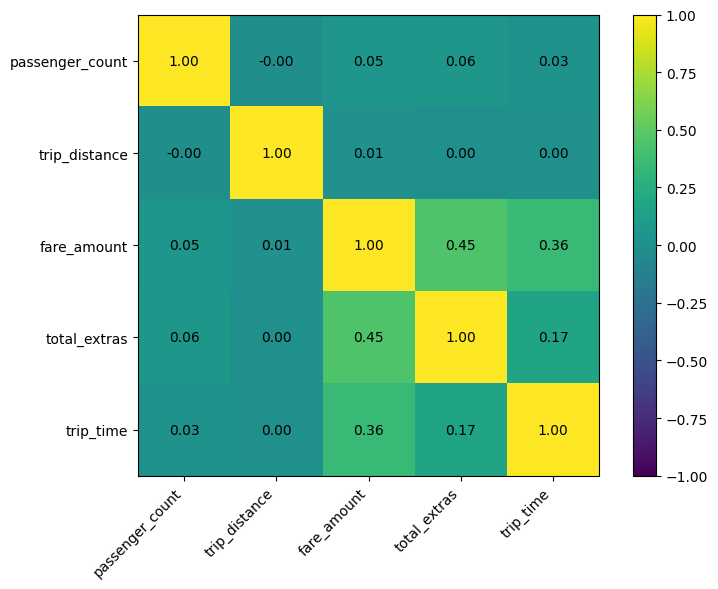

In [10]:
prefix = "yellow_tripdata_"
ext = "parquet"
path = f"data/{prefix}2024-09.{ext}"
stats(process_df(pd.read_parquet(path)))

### Dane z 2024-10

Wypełnianie NA
Usuwanie ujemnych wartości


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,2,2024-10-01 00:30:44.000000000,2024-10-01 00:48:26.000000000,1.0,3.0,1.0,N,162,246,1,18.4,1.0,0.5,1.5,0.0,1.0,24.9,2.5,0.0,0.0
1,1,2024-10-01 00:12:20.000000000,2024-10-01 00:25:25.000000000,1.0,2.2,1.0,N,48,236,1,14.2,3.5,0.5,3.8,0.0,1.0,23.0,2.5,0.0,0.0
2,1,2024-10-01 00:04:46.000000000,2024-10-01 00:13:52.000000000,1.0,2.7,1.0,N,142,24,1,13.5,3.5,0.5,3.7,0.0,1.0,22.2,2.5,0.0,0.0
3,1,2024-10-01 00:12:10.000000000,2024-10-01 00:23:01.000000000,1.0,3.1,1.0,N,233,75,1,14.2,3.5,0.5,2.0,0.0,1.0,21.2,2.5,0.0,0.0
4,1,2024-10-01 00:30:22.000000000,2024-10-01 00:30:39.000000000,1.0,0.0,1.0,N,262,262,3,3.0,3.5,0.5,0.0,0.0,1.0,8.0,2.5,0.0,0.0


Tworzenie kolumny "total_extras"
Tworzenie kolumny "trip_time"
Konwersje typów
Konwersja PULocationID na typ int16
Konwersja DOLocationID na typ int16
Konwersja RatecodeID na typ int16
Konwersja passenger_count na typ int16
Konwersja trip_time na typ float64
Konwersja total_extras na typ float64
Konwersja trip_distance na typ float64
Konwersja fare_amount na typ float64
Usuwanie pozostałych kolumn
Encoding kategoryczny
PODGLĄD DANYCH


,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,total_extras,trip_time
0,1,3.0,1,162,246,18.4,5.0,1062.0
1,1,2.2,1,48,236,14.2,7.5,785.0
2,1,2.7,1,142,24,13.5,7.5,546.0
3,1,3.1,1,233,75,14.2,7.5,651.0
4,1,0.0,1,262,262,3.0,7.5,17.0


STATYSTYKI


,passenger_count,trip_distance,fare_amount,total_extras,trip_time
count,3.757920e+06,3.757920e+06,3.757920e+06,3.757920e+06,3.757920e+06
mean,1.276070e+00,5.103387e+00,2.049890e+01,5.754863e+00,1.099347e+03
std,7.338788e-01,4.873319e+02,1.845809e+01,3.624569e+00,2.001123e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1%,1.000000e+00,0.000000e+00,3.700000e+00,1.000000e+00,5.500000e+01
5%,1.000000e+00,4.300000e-01,5.800000e+00,1.500000e+00,2.250000e+02
25%,1.000000e+00,1.030000e+00,1.000000e+01,4.000000e+00,5.040000e+02
50%,1.000000e+00,1.780000e+00,1.420000e+01,5.000000e+00,8.340000e+02
75%,1.000000e+00,3.400000e+00,2.330000e+01,6.500000e+00,1.347000e+03
95%,3.000000e+00,1.510000e+01,7.000000e+01,1.269000e+01,2.753000e+03


WARTOŚCI MINIMALNE
passenger_count    0.0
trip_distance      0.0
fare_amount        0.0
total_extras       0.0
trip_time          0.0
dtype: float64
WARTOŚCI MAKSYMALNE
passenger_count         9.00
trip_distance      366343.04
fare_amount          1680.20
total_extras          156.50
trip_time          585424.00
dtype: float64
MACIERZ KORELACJI


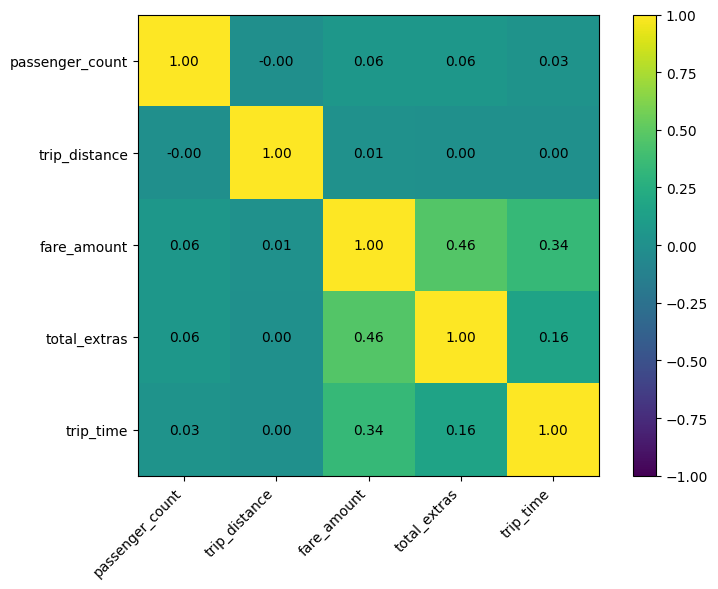

In [11]:
prefix = "yellow_tripdata_"
ext = "parquet"
path = f"data/{prefix}2024-10.{ext}"
stats(process_df(pd.read_parquet(path)))

### Dane z 2024-11

Wypełnianie NA
Usuwanie ujemnych wartości


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
1,2,2024-11-01 00:46:24.000000000,2024-11-01 00:57:17.000000000,1.0,1.93,1.0,N,239,263,2,12.8,1.0,0.5,0.0,0.0,1.0,17.8,2.5,0.0,0.0
2,1,2024-11-01 00:37:36.000000000,2024-11-01 01:28:36.000000000,1.0,34.30,5.0,N,219,265,1,259.0,0.0,0.0,15.0,0.0,1.0,275.0,0.0,0.0,0.0
3,2,2024-11-01 00:12:55.000000000,2024-11-01 00:22:17.000000000,2.0,0.93,1.0,N,186,107,1,10.0,1.0,0.5,1.0,0.0,1.0,16.0,2.5,0.0,0.0
4,2,2024-11-01 00:54:45.000000000,2024-11-01 00:59:47.000000000,1.0,0.38,1.0,N,79,79,1,6.5,1.0,0.5,1.0,0.0,1.0,12.5,2.5,0.0,0.0
5,2,2024-11-01 00:19:00.000000000,2024-11-01 00:21:28.000000000,1.0,0.48,1.0,N,237,236,2,5.1,1.0,0.5,0.0,0.0,1.0,10.1,2.5,0.0,0.0


Tworzenie kolumny "total_extras"
Tworzenie kolumny "trip_time"
Konwersje typów
Konwersja PULocationID na typ int16
Konwersja DOLocationID na typ int16
Konwersja RatecodeID na typ int16
Konwersja passenger_count na typ int16
Konwersja trip_time na typ float64
Konwersja total_extras na typ float64
Konwersja trip_distance na typ float64
Konwersja fare_amount na typ float64
Usuwanie pozostałych kolumn
Encoding kategoryczny
PODGLĄD DANYCH


,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,total_extras,trip_time
1,1,1.93,1,239,263,12.8,5.0,653.0
2,1,34.30,5,219,265,259.0,1.0,3060.0
3,2,0.93,1,186,107,10.0,5.0,562.0
4,1,0.38,1,79,79,6.5,5.0,302.0
5,1,0.48,1,237,236,5.1,5.0,148.0


STATYSTYKI


,passenger_count,trip_distance,fare_amount,total_extras,trip_time
count,3.573308e+06,3.573308e+06,3.573308e+06,3.573308e+06,3.573308e+06
mean,1.293664e+00,5.180060e+00,1.997072e+01,5.609512e+00,1.071434e+03
std,7.487415e-01,4.997494e+02,1.784238e+02,3.495134e+00,2.002116e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1%,1.000000e+00,0.000000e+00,3.700000e+00,1.000000e+00,5.800000e+01
5%,1.000000e+00,4.300000e-01,5.800000e+00,1.500000e+00,2.190000e+02
25%,1.000000e+00,1.000000e+00,9.300000e+00,4.000000e+00,4.860000e+02
50%,1.000000e+00,1.720000e+00,1.420000e+01,5.000000e+00,8.060000e+02
75%,1.000000e+00,3.290000e+00,2.260000e+01,6.500000e+00,1.301000e+03
95%,3.000000e+00,1.340000e+01,6.460000e+01,1.269000e+01,2.665000e+03


WARTOŚCI MINIMALNE
passenger_count    0.0
trip_distance      0.0
fare_amount        0.0
total_extras       0.0
trip_time          0.0
dtype: float64
WARTOŚCI MAKSYMALNE
passenger_count         9.00
trip_distance      398608.62
fare_amount        335544.44
total_extras          143.38
trip_time          345077.00
dtype: float64
MACIERZ KORELACJI


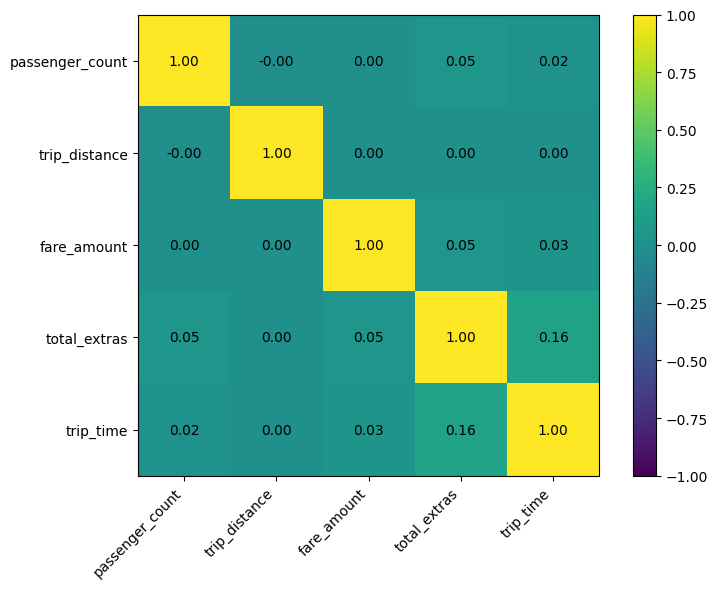

In [12]:
prefix = "yellow_tripdata_"
ext = "parquet"
path = f"data/{prefix}2024-11.{ext}"
stats(process_df(pd.read_parquet(path)))

### Dane z 2024-12

Wypełnianie NA
Usuwanie ujemnych wartości


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,2,2024-12-01 00:12:27.000000000,2024-12-01 00:31:12.000000000,1.0,9.76,1.0,N,138,33,1,38.0,6.0,0.5,4.72,0.00,1.0,51.97,0.0,1.75,0.0
1,2,2024-11-30 23:56:04.000000000,2024-12-01 00:28:15.000000000,1.0,7.62,1.0,N,158,42,1,37.3,1.0,0.5,8.46,0.00,1.0,50.76,2.5,0.00,0.0
2,2,2024-12-01 00:50:35.000000000,2024-12-01 01:24:46.000000000,4.0,20.07,2.0,N,132,236,2,70.0,0.0,0.5,0.00,6.94,1.0,82.69,2.5,1.75,0.0
3,2,2024-12-01 00:18:16.000000000,2024-12-01 00:33:16.000000000,3.0,2.34,1.0,N,142,186,1,15.6,1.0,0.5,4.12,0.00,1.0,24.72,2.5,0.00,0.0
4,2,2024-12-01 00:56:13.000000000,2024-12-01 01:18:25.000000000,1.0,5.05,1.0,N,107,80,1,26.8,1.0,0.5,5.00,0.00,1.0,36.80,2.5,0.00,0.0


Tworzenie kolumny "total_extras"
Tworzenie kolumny "trip_time"
Konwersje typów
Konwersja PULocationID na typ int16
Konwersja DOLocationID na typ int16
Konwersja RatecodeID na typ int16
Konwersja passenger_count na typ int16
Konwersja trip_time na typ float64
Konwersja total_extras na typ float64
Konwersja trip_distance na typ float64
Konwersja fare_amount na typ float64
Usuwanie pozostałych kolumn
Encoding kategoryczny
PODGLĄD DANYCH


,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,total_extras,trip_time
0,1,9.76,1,138,33,38.0,9.25,1125.0
1,1,7.62,1,158,42,37.3,5.00,1931.0
2,4,20.07,2,132,236,70.0,12.69,2051.0
3,3,2.34,1,142,186,15.6,5.00,900.0
4,1,5.05,1,107,80,26.8,5.00,1332.0


STATYSTYKI


,passenger_count,trip_distance,fare_amount,total_extras,trip_time
count,3.588969e+06,3.588969e+06,3.588969e+06,3.588969e+06,3.588969e+06
mean,1.328295e+00,5.041588e+00,2.054871e+01,5.703613e+00,1.124973e+03
std,7.918392e-01,4.680691e+02,1.865221e+01,3.521808e+00,2.045551e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1%,1.000000e+00,0.000000e+00,3.700000e+00,1.000000e+00,4.500000e+01
5%,1.000000e+00,4.000000e-01,5.800000e+00,1.500000e+00,2.130000e+02
25%,1.000000e+00,9.800000e-01,9.300000e+00,4.000000e+00,4.850000e+02
50%,1.000000e+00,1.690000e+00,1.461000e+01,5.000000e+00,8.300000e+02
75%,1.000000e+00,3.250000e+00,2.400000e+01,6.500000e+00,1.385000e+03
95%,3.000000e+00,1.360000e+01,6.740000e+01,1.269000e+01,2.861000e+03


WARTOŚCI MINIMALNE
passenger_count    0.0
trip_distance      0.0
fare_amount        0.0
total_extras       0.0
trip_time          0.0
dtype: float64
WARTOŚCI MAKSYMALNE
passenger_count         9.00
trip_distance      328827.63
fare_amount          3033.10
total_extras          122.90
trip_time          359535.00
dtype: float64
MACIERZ KORELACJI


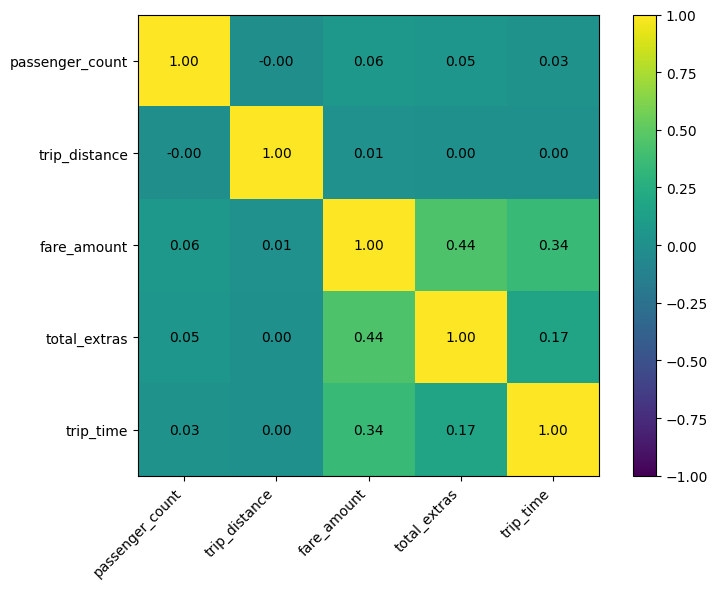

In [13]:
prefix = "yellow_tripdata_"
ext = "parquet"
path = f"data/{prefix}2024-12.{ext}"
stats(process_df(pd.read_parquet(path)))

### Dane z 2025-01

Wypełnianie NA
Usuwanie ujemnych wartości


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,1,2025-01-01 00:18:38.000000000,2025-01-01 00:26:59.000000000,1.0,1.60,1.0,N,229,237,1,10.0,3.5,0.5,3.00,0.0,1.0,18.00,2.5,0.0,0.0
1,1,2025-01-01 00:32:40.000000000,2025-01-01 00:35:13.000000000,1.0,0.50,1.0,N,236,237,1,5.1,3.5,0.5,2.02,0.0,1.0,12.12,2.5,0.0,0.0
2,1,2025-01-01 00:44:04.000000000,2025-01-01 00:46:01.000000000,1.0,0.60,1.0,N,141,141,1,5.1,3.5,0.5,2.00,0.0,1.0,12.10,2.5,0.0,0.0
3,2,2025-01-01 00:14:27.000000000,2025-01-01 00:20:01.000000000,3.0,0.52,1.0,N,244,244,2,7.2,1.0,0.5,0.00,0.0,1.0,9.70,0.0,0.0,0.0
4,2,2025-01-01 00:21:34.000000000,2025-01-01 00:25:06.000000000,3.0,0.66,1.0,N,244,116,2,5.8,1.0,0.5,0.00,0.0,1.0,8.30,0.0,0.0,0.0


Tworzenie kolumny "total_extras"
Tworzenie kolumny "trip_time"
Konwersje typów
Konwersja PULocationID na typ int16
Konwersja DOLocationID na typ int16
Konwersja RatecodeID na typ int16
Konwersja passenger_count na typ int16
Konwersja trip_time na typ float64
Konwersja total_extras na typ float64
Konwersja trip_distance na typ float64
Konwersja fare_amount na typ float64
Usuwanie pozostałych kolumn
Encoding kategoryczny
PODGLĄD DANYCH


,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,total_extras,trip_time
0,1,1.60,1,229,237,10.0,7.5,501.0
1,1,0.50,1,236,237,5.1,7.5,153.0
2,1,0.60,1,141,141,5.1,7.5,117.0
3,3,0.52,1,244,244,7.2,2.5,334.0
4,3,0.66,1,244,116,5.8,2.5,212.0


STATYSTYKI


,passenger_count,trip_distance,fare_amount,total_extras,trip_time
count,3.330269e+06,3.330269e+06,3.330269e+06,3.330269e+06,3.330269e+06
mean,1.255771e+00,5.387734e+00,1.832522e+01,5.958234e+00,9.031621e+02
std,7.046451e-01,5.082198e+02,4.733957e+02,3.499711e+00,1.640516e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1%,1.000000e+00,0.000000e+00,4.400000e+00,1.000000e+00,6.000000e+01
5%,1.000000e+00,4.000000e-01,5.800000e+00,1.500000e+00,2.050000e+02
25%,1.000000e+00,9.900000e-01,8.600000e+00,4.000000e+00,4.360000e+02
50%,1.000000e+00,1.670000e+00,1.280000e+01,5.000000e+00,7.000000e+02
75%,1.000000e+00,3.090000e+00,1.980000e+01,7.250000e+00,1.099000e+03
95%,3.000000e+00,1.189000e+01,5.410000e+01,1.194000e+01,2.180000e+03


WARTOŚCI MINIMALNE
passenger_count    0.0
trip_distance      0.0
fare_amount        0.0
total_extras       0.0
trip_time          0.0
dtype: float64
WARTOŚCI MAKSYMALNE
passenger_count         9.00
trip_distance      276099.95
fare_amount        863372.12
total_extras          174.44
trip_time          337579.00
dtype: float64
MACIERZ KORELACJI


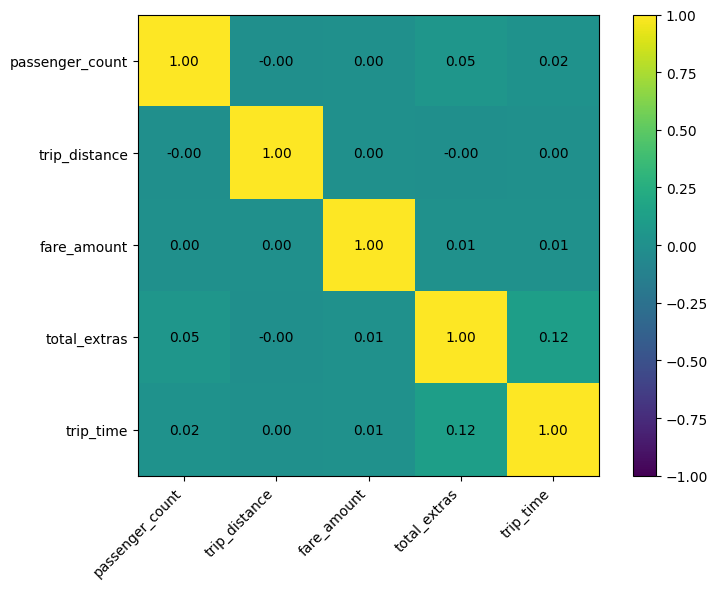

In [14]:
prefix = "yellow_tripdata_"
ext = "parquet"
path = f"data/{prefix}2025-01.{ext}"
stats(process_df(pd.read_parquet(path)))

### Dane z 2025-02

Wypełnianie NA
Usuwanie ujemnych wartości


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,2,2025-02-01 00:12:18.000000000,2025-02-01 00:32:33.000000000,3.0,3.12,1.0,N,246,79,1,19.8,1.00,0.5,5.11,0.0,1.0,30.66,2.5,0.0,0.75
1,2,2025-02-01 00:40:04.000000000,2025-02-01 00:49:15.000000000,1.0,1.40,1.0,N,114,79,1,10.0,1.00,0.5,3.15,0.0,1.0,18.90,2.5,0.0,0.75
2,1,2025-02-01 00:06:09.000000000,2025-02-01 00:11:51.000000000,0.0,0.40,1.0,N,211,144,1,6.5,4.25,0.5,1.00,0.0,1.0,13.25,2.5,0.0,0.75
3,1,2025-02-01 00:15:13.000000000,2025-02-01 00:20:19.000000000,0.0,0.70,1.0,N,113,249,1,7.2,4.25,0.5,2.00,0.0,1.0,14.95,2.5,0.0,0.75
4,2,2025-02-01 00:02:52.000000000,2025-02-01 00:20:25.000000000,1.0,4.19,1.0,N,113,263,1,19.8,1.00,0.5,5.11,0.0,1.0,30.66,2.5,0.0,0.75


Tworzenie kolumny "total_extras"
Tworzenie kolumny "trip_time"
Konwersje typów
Konwersja PULocationID na typ int16
Konwersja DOLocationID na typ int16
Konwersja RatecodeID na typ int16
Konwersja passenger_count na typ int16
Konwersja trip_time na typ float64
Konwersja total_extras na typ float64
Konwersja trip_distance na typ float64
Konwersja fare_amount na typ float64
Usuwanie pozostałych kolumn
Encoding kategoryczny
PODGLĄD DANYCH


,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,total_extras,trip_time
0,3,3.12,1,246,79,19.8,5.75,1215.0
1,1,1.40,1,114,79,10.0,5.75,551.0
2,0,0.40,1,211,144,6.5,9.00,342.0
3,0,0.70,1,113,249,7.2,9.00,306.0
4,1,4.19,1,113,263,19.8,5.75,1053.0


STATYSTYKI


,passenger_count,trip_distance,fare_amount,total_extras,trip_time
count,3.394310e+06,3.394310e+06,3.394310e+06,3.394310e+06,3.394310e+06
mean,1.219784e+00,5.690378e+00,1.816038e+01,5.751774e+00,9.248798e+02
std,6.554082e-01,5.172606e+02,7.367913e+01,3.522136e+00,1.624281e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1%,1.000000e+00,0.000000e+00,4.400000e+00,1.500000e+00,6.000000e+01
5%,1.000000e+00,4.000000e-01,5.800000e+00,1.500000e+00,2.120000e+02
25%,1.000000e+00,1.000000e+00,9.300000e+00,4.000000e+00,4.550000e+02
50%,1.000000e+00,1.700000e+00,1.350000e+01,4.750000e+00,7.280000e+02
75%,1.000000e+00,3.150000e+00,2.050000e+01,7.250000e+00,1.132000e+03
95%,2.000000e+00,1.110000e+01,4.920000e+01,1.150000e+01,2.181000e+03


WARTOŚCI MINIMALNE
passenger_count    0.0
trip_distance      0.0
fare_amount        0.0
total_extras       0.0
trip_time          0.0
dtype: float64
WARTOŚCI MAKSYMALNE
passenger_count         9.00
trip_distance      228782.51
fare_amount        132531.36
total_extras          117.62
trip_time          513880.00
dtype: float64
MACIERZ KORELACJI


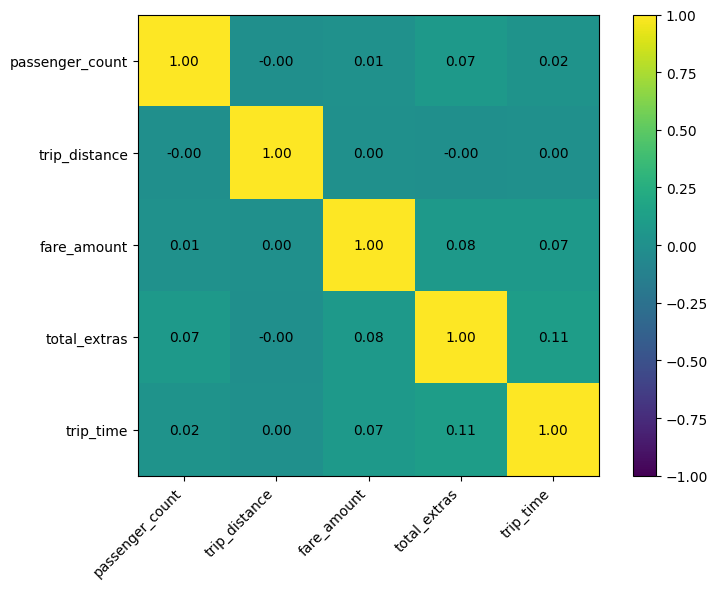

In [15]:
prefix = "yellow_tripdata_"
ext = "parquet"
path = f"data/{prefix}2025-02.{ext}"
stats(process_df(pd.read_parquet(path)))

### Dane z 2025-03

Wypełnianie NA
Usuwanie ujemnych wartości


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,1,2025-03-01 00:17:16.000000000,2025-03-01 00:25:52.000000000,1.0,0.90,1.0,N,140,236,1,7.9,3.50,0.5,2.60,0.0,1.0,15.50,2.5,0.0,0.00
1,1,2025-03-01 00:37:38.000000000,2025-03-01 00:43:51.000000000,1.0,0.60,1.0,N,140,262,1,6.5,3.50,0.5,2.30,0.0,1.0,13.80,2.5,0.0,0.00
2,2,2025-03-01 00:24:35.000000000,2025-03-01 00:39:49.000000000,1.0,1.94,1.0,N,161,68,1,14.9,1.00,0.5,5.16,0.0,1.0,25.81,2.5,0.0,0.75
3,2,2025-03-01 00:56:16.000000000,2025-03-01 01:01:35.000000000,2.0,0.95,1.0,N,231,13,1,7.2,1.00,0.5,2.59,0.0,1.0,15.54,2.5,0.0,0.75
4,1,2025-03-01 00:01:44.000000000,2025-03-01 00:10:00.000000000,1.0,1.50,1.0,N,163,236,1,8.6,4.25,0.5,2.85,0.0,1.0,17.20,2.5,0.0,0.75


Tworzenie kolumny "total_extras"
Tworzenie kolumny "trip_time"
Konwersje typów
Konwersja PULocationID na typ int16
Konwersja DOLocationID na typ int16
Konwersja RatecodeID na typ int16
Konwersja passenger_count na typ int16
Konwersja trip_time na typ float64
Konwersja total_extras na typ float64
Konwersja trip_distance na typ float64
Konwersja fare_amount na typ float64
Usuwanie pozostałych kolumn
Encoding kategoryczny
PODGLĄD DANYCH


,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,total_extras,trip_time
0,1,0.90,1,140,236,7.9,7.50,516.0
1,1,0.60,1,140,262,6.5,7.50,373.0
2,1,1.94,1,161,68,14.9,5.75,914.0
3,2,0.95,1,231,13,7.2,5.75,319.0
4,1,1.50,1,163,236,8.6,9.00,496.0


STATYSTYKI


,passenger_count,trip_distance,fare_amount,total_extras,trip_time
count,3.935915e+06,3.935915e+06,3.935915e+06,3.935915e+06,3.935915e+06
mean,1.232372e+00,5.946856e+00,1.928333e+01,5.822173e+00,9.606923e+02
std,6.652796e-01,5.489529e+02,2.885290e+01,3.684026e+00,1.671437e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1%,1.000000e+00,0.000000e+00,4.400000e+00,1.500000e+00,1.200000e+01
5%,1.000000e+00,4.100000e-01,5.800000e+00,1.500000e+00,2.050000e+02
25%,1.000000e+00,1.030000e+00,9.300000e+00,4.000000e+00,4.610000e+02
50%,1.000000e+00,1.790000e+00,1.411000e+01,4.750000e+00,7.440000e+02
75%,1.000000e+00,3.400000e+00,2.197000e+01,7.250000e+00,1.166000e+03
95%,2.000000e+00,1.212000e+01,5.620000e+01,1.269000e+01,2.356000e+03


WARTOŚCI MINIMALNE
passenger_count    0.0
trip_distance      0.0
fare_amount        0.0
total_extras       0.0
trip_time          0.0
dtype: float64
WARTOŚCI MAKSYMALNE
passenger_count         9.00
trip_distance      281085.57
fare_amount         46263.88
total_extras          921.87
trip_time          376550.00
dtype: float64
MACIERZ KORELACJI


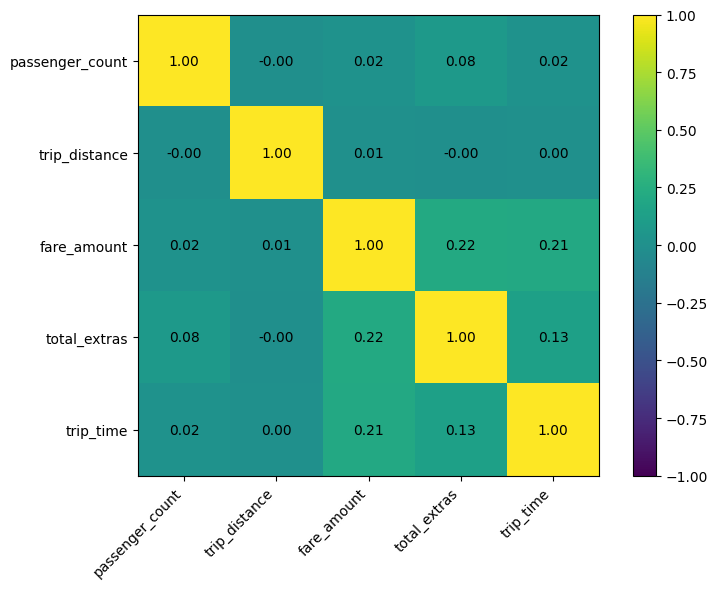

In [16]:
prefix = "yellow_tripdata_"
ext = "parquet"
path = f"data/{prefix}2025-03.{ext}"
stats(process_df(pd.read_parquet(path)))

### Dane z 2025-04

Wypełnianie NA
Usuwanie ujemnych wartości


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,1,2025-04-01 00:47:06.000000000,2025-04-01 01:13:25.000000000,1.0,9.50,1.0,N,138,230,1,38.7,11.00,0.5,11.65,6.94,1.0,69.79,2.5,1.75,0.75
1,2,2025-04-01 00:27:35.000000000,2025-04-01 00:38:19.000000000,2.0,3.77,1.0,N,138,92,1,17.0,6.00,0.5,4.90,0.00,1.0,31.15,0.0,1.75,0.00
2,2,2025-04-01 00:24:07.000000000,2025-04-01 00:35:12.000000000,1.0,5.41,1.0,N,132,130,1,22.6,1.00,0.5,5.37,0.00,1.0,32.22,0.0,1.75,0.00
3,1,2025-04-01 00:56:30.000000000,2025-04-01 01:00:49.000000000,2.0,0.60,1.0,N,79,4,1,6.5,4.25,0.5,2.45,0.00,1.0,14.70,2.5,0.00,0.75
4,2,2025-04-01 00:00:17.000000000,2025-04-01 00:16:19.000000000,1.0,0.43,1.0,N,161,229,2,4.4,1.00,0.5,0.00,0.00,1.0,10.15,2.5,0.00,0.75


Tworzenie kolumny "total_extras"
Tworzenie kolumny "trip_time"
Konwersje typów
Konwersja PULocationID na typ int16
Konwersja DOLocationID na typ int16
Konwersja RatecodeID na typ int16
Konwersja passenger_count na typ int16
Konwersja trip_time na typ float64
Konwersja total_extras na typ float64
Konwersja trip_distance na typ float64
Konwersja fare_amount na typ float64
Usuwanie pozostałych kolumn
Encoding kategoryczny
PODGLĄD DANYCH


,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,total_extras,trip_time
0,1,9.50,1,138,230,38.7,24.44,1579.0
1,2,3.77,1,138,92,17.0,9.25,644.0
2,1,5.41,1,132,130,22.6,4.25,665.0
3,2,0.60,1,79,4,6.5,9.00,259.0
4,1,0.43,1,161,229,4.4,5.75,962.0


STATYSTYKI


,passenger_count,trip_distance,fare_amount,total_extras,trip_time
count,3.783280e+06,3.783280e+06,3.783280e+06,3.783280e+06,3.783280e+06
mean,1.254677e+00,6.594399e+00,1.942261e+01,5.967945e+00,9.971993e+02
std,6.960163e-01,6.283898e+02,1.733214e+01,3.641630e+00,1.803971e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1%,1.000000e+00,0.000000e+00,4.400000e+00,1.000000e+00,4.000000e+00
5%,1.000000e+00,4.300000e-01,5.800000e+00,1.500000e+00,1.990000e+02
25%,1.000000e+00,1.030000e+00,9.300000e+00,4.000000e+00,4.700000e+02
50%,1.000000e+00,1.790000e+00,1.420000e+01,5.000000e+00,7.710000e+02
75%,1.000000e+00,3.420000e+00,2.211000e+01,7.250000e+00,1.218000e+03
95%,3.000000e+00,1.241000e+01,5.791000e+01,1.269000e+01,2.463000e+03


WARTOŚCI MINIMALNE
passenger_count    0.0
trip_distance      0.0
fare_amount        0.0
total_extras       0.0
trip_time          0.0
dtype: float64
WARTOŚCI MAKSYMALNE
passenger_count         9.00
trip_distance      386088.43
fare_amount          1777.50
total_extras          133.24
trip_time          892846.00
dtype: float64
MACIERZ KORELACJI


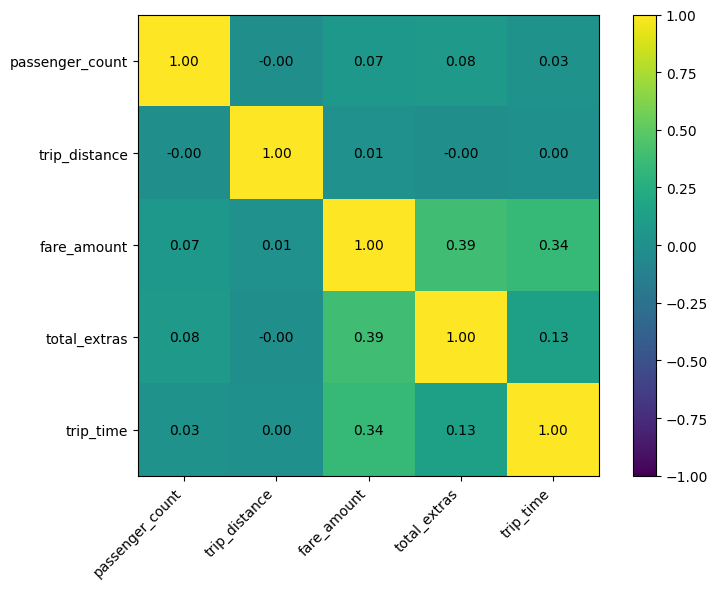

In [17]:
prefix = "yellow_tripdata_"
ext = "parquet"
path = f"data/{prefix}2025-04.{ext}"
stats(process_df(pd.read_parquet(path)))

### Dane z 2025-05

Wypełnianie NA
Usuwanie ujemnych wartości


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,1,2025-05-01 00:07:06.000000000,2025-05-01 00:24:15.000000000,1.0,3.70,1.0,N,140,202,1,18.4,4.25,0.5,4.85,0.00,1.0,29.00,2.5,0.00,0.75
1,2,2025-05-01 00:07:44.000000000,2025-05-01 00:14:27.000000000,1.0,1.03,1.0,N,234,161,1,8.6,1.00,0.5,4.30,0.00,1.0,18.65,2.5,0.00,0.75
2,2,2025-05-01 00:15:56.000000000,2025-05-01 00:23:53.000000000,1.0,1.57,1.0,N,161,234,2,10.0,1.00,0.5,0.00,0.00,1.0,15.75,2.5,0.00,0.75
3,2,2025-05-01 00:00:09.000000000,2025-05-01 00:25:29.000000000,1.0,9.48,1.0,N,138,90,1,40.8,6.00,0.5,11.70,6.94,1.0,71.94,2.5,1.75,0.75
4,2,2025-05-01 00:45:07.000000000,2025-05-01 00:52:45.000000000,1.0,1.80,1.0,N,90,231,1,10.0,1.00,0.5,1.50,0.00,1.0,17.25,2.5,0.00,0.75


Tworzenie kolumny "total_extras"
Tworzenie kolumny "trip_time"
Konwersje typów
Konwersja PULocationID na typ int16
Konwersja DOLocationID na typ int16
Konwersja RatecodeID na typ int16
Konwersja passenger_count na typ int16
Konwersja trip_time na typ float64
Konwersja total_extras na typ float64
Konwersja trip_distance na typ float64
Konwersja fare_amount na typ float64
Usuwanie pozostałych kolumn
Encoding kategoryczny
PODGLĄD DANYCH


,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,total_extras,trip_time
0,1,3.70,1,140,202,18.4,9.00,1029.0
1,1,1.03,1,234,161,8.6,5.75,403.0
2,1,1.57,1,161,234,10.0,5.75,477.0
3,1,9.48,1,138,90,40.8,19.44,1520.0
4,1,1.80,1,90,231,10.0,5.75,458.0


STATYSTYKI


,passenger_count,trip_distance,fare_amount,total_extras,trip_time
count,4.265750e+06,4.265750e+06,4.265750e+06,4.265750e+06,4.265750e+06
mean,1.228198e+00,7.045473e+00,2.046175e+01,5.764375e+00,1.072733e+03
std,6.505946e-01,6.063055e+02,1.833694e+01,3.741081e+00,1.727974e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1%,1.000000e+00,0.000000e+00,2.950000e+00,1.000000e+00,0.000000e+00
5%,1.000000e+00,4.000000e-01,5.800000e+00,1.500000e+00,1.940000e+02
25%,1.000000e+00,1.060000e+00,1.000000e+01,4.000000e+00,4.960000e+02
50%,1.000000e+00,1.870000e+00,1.490000e+01,4.750000e+00,8.260000e+02
75%,1.000000e+00,3.690000e+00,2.400000e+01,7.250000e+00,1.321000e+03
95%,2.000000e+00,1.323000e+01,6.250000e+01,1.269000e+01,2.720000e+03


WARTOŚCI MINIMALNE
passenger_count    0.0
trip_distance      0.0
fare_amount        0.0
total_extras       0.0
trip_time          0.0
dtype: float64
WARTOŚCI MAKSYMALNE
passenger_count         9.00
trip_distance      263103.98
fare_amount          1583.60
total_extras          149.17
trip_time          459883.00
dtype: float64
MACIERZ KORELACJI


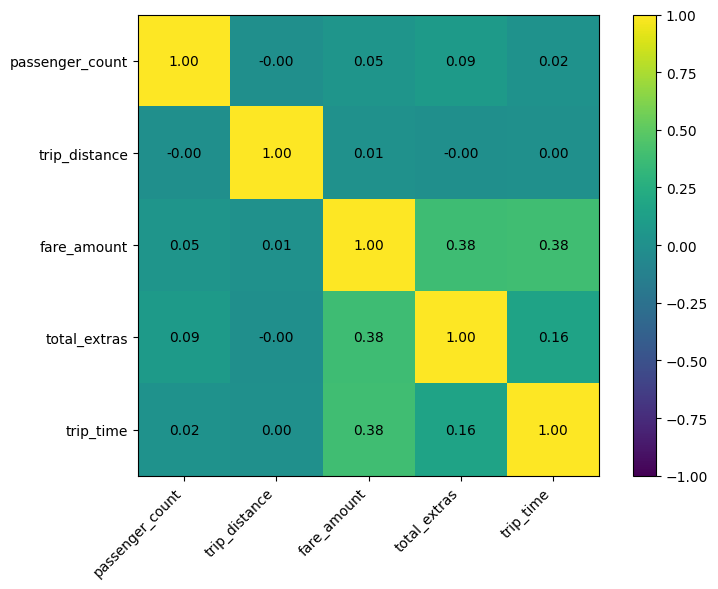

In [18]:
prefix = "yellow_tripdata_"
ext = "parquet"
path = f"data/{prefix}2025-05.{ext}"
stats(process_df(pd.read_parquet(path)))

### Dane z 2025-06

Wypełnianie NA
Usuwanie ujemnych wartości


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,1,2025-06-01 00:02:50.000000000,2025-06-01 00:39:51.000000000,1.0,10.00,1.0,N,138,50,1,47.8,11.00,0.5,20.15,6.94,1.0,87.39,2.5,1.75,0.75
1,2,2025-06-01 00:11:27.000000000,2025-06-01 00:35:35.000000000,1.0,3.93,1.0,N,158,237,1,24.7,1.00,0.5,6.09,0.00,1.0,36.54,2.5,0.00,0.75
2,1,2025-06-01 00:43:47.000000000,2025-06-01 00:49:16.000000000,0.0,0.70,1.0,N,230,163,1,7.2,4.25,0.5,2.59,0.00,1.0,15.54,2.5,0.00,0.75
3,1,2025-06-01 00:01:15.000000000,2025-06-01 00:42:16.000000000,1.0,17.00,2.0,N,132,232,1,70.0,3.25,0.5,5.00,0.00,1.0,79.75,2.5,0.00,0.75
4,7,2025-06-01 00:16:32.000000000,2025-06-01 00:16:32.000000000,1.0,2.22,1.0,N,48,234,1,20.5,0.00,0.5,5.25,0.00,1.0,31.50,2.5,0.00,0.75


Tworzenie kolumny "total_extras"
Tworzenie kolumny "trip_time"
Konwersje typów
Konwersja PULocationID na typ int16
Konwersja DOLocationID na typ int16
Konwersja RatecodeID na typ int16
Konwersja passenger_count na typ int16
Konwersja trip_time na typ float64
Konwersja total_extras na typ float64
Konwersja trip_distance na typ float64
Konwersja fare_amount na typ float64
Usuwanie pozostałych kolumn
Encoding kategoryczny
PODGLĄD DANYCH


,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,total_extras,trip_time
0,1,10.00,1,138,50,47.8,24.44,2221.0
1,1,3.93,1,158,237,24.7,5.75,1448.0
2,0,0.70,1,230,163,7.2,9.00,329.0
3,1,17.00,2,132,232,70.0,8.00,2461.0
4,1,2.22,1,48,234,20.5,4.75,0.0


STATYSTYKI


,passenger_count,trip_distance,fare_amount,total_extras,trip_time
count,4.046413e+06,4.046413e+06,4.046413e+06,4.046413e+06,4.046413e+06
mean,1.222230e+00,7.015736e+00,2.093395e+01,5.645847e+00,1.042308e+03
std,6.469264e-01,6.593716e+02,1.628298e+02,3.755256e+00,1.649354e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1%,1.000000e+00,0.000000e+00,4.400000e+00,8.000000e-01,0.000000e+00
5%,1.000000e+00,3.900000e-01,5.800000e+00,1.500000e+00,1.850000e+02
25%,1.000000e+00,1.070000e+00,1.000000e+01,2.250000e+00,4.830000e+02
50%,1.000000e+00,1.900000e+00,1.510000e+01,4.750000e+00,8.070000e+02
75%,1.000000e+00,3.830000e+00,2.470000e+01,7.250000e+00,1.291000e+03
95%,2.000000e+00,1.322000e+01,6.180000e+01,1.269000e+01,2.643000e+03


WARTOŚCI MINIMALNE
passenger_count    0.0
trip_distance      0.0
fare_amount        0.0
total_extras       0.0
trip_time          0.0
dtype: float64
WARTOŚCI MAKSYMALNE
passenger_count         9.00
trip_distance      261262.39
fare_amount        325478.05
total_extras          720.80
trip_time          515766.00
dtype: float64
MACIERZ KORELACJI


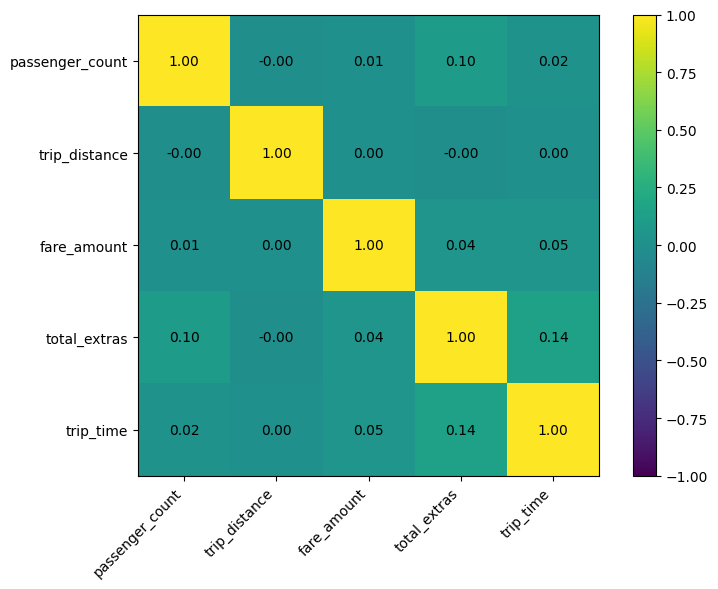

In [19]:
prefix = "yellow_tripdata_"
ext = "parquet"
path = f"data/{prefix}2025-06.{ext}"
stats(process_df(pd.read_parquet(path)))

### Dane z 2025-07

Wypełnianie NA
Usuwanie ujemnych wartości


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,1,2025-07-01 00:29:37.000000000,2025-07-01 00:45:30.000000000,1.0,7.30,1.0,N,138,74,1,29.6,7.75,0.5,9.00,6.94,1.0,54.79,0.0,1.75,0.00
1,1,2025-07-01 00:23:28.000000000,2025-07-01 01:07:44.000000000,1.0,17.70,2.0,N,132,142,1,70.0,4.25,0.5,5.00,0.00,1.0,80.75,2.5,1.75,0.00
2,2,2025-07-01 00:53:50.000000000,2025-07-01 01:27:12.000000000,1.0,9.98,1.0,N,138,48,1,43.6,6.00,0.5,10.87,0.00,1.0,66.97,2.5,1.75,0.75
3,2,2025-07-01 00:58:49.000000000,2025-07-01 01:15:55.000000000,1.0,10.27,1.0,N,138,229,1,38.7,6.00,0.5,14.10,6.94,1.0,72.24,2.5,1.75,0.75
4,2,2025-07-01 00:09:22.000000000,2025-07-01 00:23:54.000000000,1.0,2.94,1.0,N,211,97,1,17.0,1.00,0.5,3.00,0.00,1.0,25.75,2.5,0.00,0.75


Tworzenie kolumny "total_extras"
Tworzenie kolumny "trip_time"
Konwersje typów
Konwersja PULocationID na typ int16
Konwersja DOLocationID na typ int16
Konwersja RatecodeID na typ int16
Konwersja passenger_count na typ int16
Konwersja trip_time na typ float64
Konwersja total_extras na typ float64
Konwersja trip_distance na typ float64
Konwersja fare_amount na typ float64
Usuwanie pozostałych kolumn
Encoding kategoryczny
PODGLĄD DANYCH


,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,total_extras,trip_time
0,1,7.30,1,138,74,29.6,17.94,953.0
1,1,17.70,2,132,142,70.0,10.00,2656.0
2,1,9.98,1,138,48,43.6,12.50,2002.0
3,1,10.27,1,138,229,38.7,19.44,1026.0
4,1,2.94,1,211,97,17.0,5.75,872.0


STATYSTYKI


,passenger_count,trip_distance,fare_amount,total_extras,trip_time
count,3.651388e+06,3.651388e+06,3.651388e+06,3.651388e+06,3.651388e+06
mean,1.238240e+00,6.762454e+00,2.052754e+01,5.631600e+00,1.023914e+03
std,6.736636e-01,6.342907e+02,1.844719e+01,4.585483e+00,1.560954e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1%,1.000000e+00,0.000000e+00,4.400000e+00,5.000000e-01,0.000000e+00
5%,1.000000e+00,3.800000e-01,5.800000e+00,1.500000e+00,1.860000e+02
25%,1.000000e+00,1.070000e+00,1.000000e+01,2.500000e+00,4.830000e+02
50%,1.000000e+00,1.900000e+00,1.490000e+01,4.750000e+00,8.040000e+02
75%,1.000000e+00,3.850000e+00,2.400000e+01,7.250000e+00,1.276000e+03
95%,3.000000e+00,1.340000e+01,6.115000e+01,1.250000e+01,2.565000e+03


WARTOŚCI MINIMALNE
passenger_count    0.0
trip_distance      0.0
fare_amount        0.0
total_extras       0.0
trip_time          0.0
dtype: float64
WARTOŚCI MAKSYMALNE
passenger_count         9.00
trip_distance      397994.37
fare_amount          2495.00
total_extras         5260.57
trip_time          450444.00
dtype: float64
MACIERZ KORELACJI


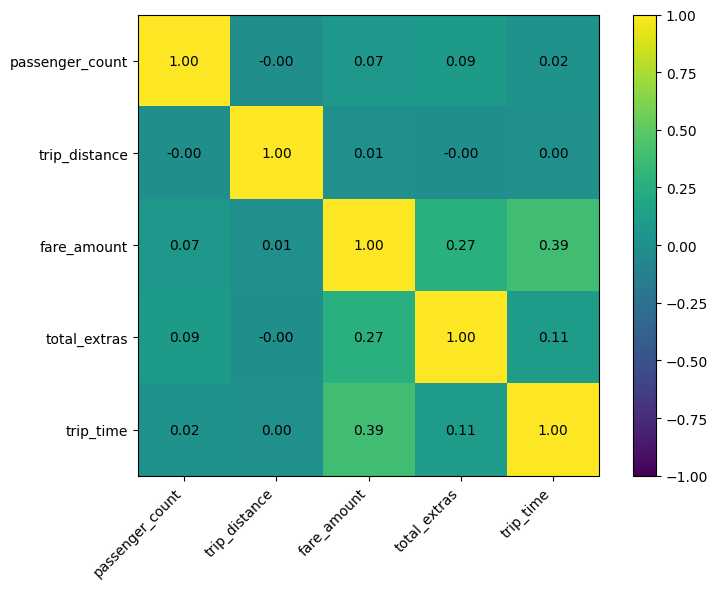

In [20]:
prefix = "yellow_tripdata_"
ext = "parquet"
path = f"data/{prefix}2025-07.{ext}"
stats(process_df(pd.read_parquet(path)))

### Dane z 2025-08

Wypełnianie NA
Usuwanie ujemnych wartości


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,2,2025-08-01 00:52:23.000000000,2025-08-01 01:12:20.000000000,1.0,8.44,1.0,N,138,141,1,33.8,6.0,0.5,5.00,6.94,1.0,57.49,2.5,1.75,0.00
1,2,2025-08-01 00:03:01.000000000,2025-08-01 00:15:33.000000000,2.0,4.98,1.0,N,138,193,1,21.2,6.0,0.5,0.00,0.00,1.0,30.45,0.0,1.75,0.00
2,7,2025-08-01 00:24:38.000000000,2025-08-01 00:24:38.000000000,2.0,1.89,1.0,N,249,45,1,14.2,0.0,0.5,3.99,0.00,1.0,23.94,2.5,0.00,0.75
3,7,2025-08-01 00:48:19.000000000,2025-08-01 00:48:19.000000000,1.0,2.35,1.0,N,79,229,1,11.4,0.0,0.5,3.43,0.00,1.0,20.58,2.5,0.00,0.75
4,2,2025-08-01 00:25:34.000000000,2025-08-01 00:33:18.000000000,1.0,2.14,1.0,N,43,48,1,11.4,1.0,0.5,2.57,0.00,1.0,19.72,2.5,0.00,0.75


Tworzenie kolumny "total_extras"
Tworzenie kolumny "trip_time"
Konwersje typów
Konwersja PULocationID na typ int16
Konwersja DOLocationID na typ int16
Konwersja RatecodeID na typ int16
Konwersja passenger_count na typ int16
Konwersja trip_time na typ float64
Konwersja total_extras na typ float64
Konwersja trip_distance na typ float64
Konwersja fare_amount na typ float64
Usuwanie pozostałych kolumn
Encoding kategoryczny
PODGLĄD DANYCH


,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,total_extras,trip_time
0,1,8.44,1,138,141,33.8,18.69,1197.0
1,2,4.98,1,138,193,21.2,9.25,752.0
2,2,1.89,1,249,45,14.2,4.75,0.0
3,1,2.35,1,79,229,11.4,4.75,0.0
4,1,2.14,1,43,48,11.4,5.75,464.0


STATYSTYKI


,passenger_count,trip_distance,fare_amount,total_extras,trip_time
count,3.312477e+06,3.312477e+06,3.312477e+06,3.312477e+06,3.312477e+06
mean,1.257411e+00,6.806898e+00,2.033025e+01,5.717894e+00,1.034873e+03
std,6.876813e-01,6.430066e+02,1.927078e+01,3.732538e+00,1.792369e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1%,1.000000e+00,0.000000e+00,2.150000e+00,5.000000e-01,0.000000e+00
5%,1.000000e+00,4.000000e-01,5.100000e+00,1.500000e+00,1.840000e+02
25%,1.000000e+00,1.100000e+00,9.300000e+00,4.000000e+00,4.790000e+02
50%,1.000000e+00,1.990000e+00,1.420000e+01,4.750000e+00,7.990000e+02
75%,1.000000e+00,4.160000e+00,2.361000e+01,7.250000e+00,1.277000e+03
95%,3.000000e+00,1.456000e+01,6.530000e+01,1.269000e+01,2.671000e+03


WARTOŚCI MINIMALNE
passenger_count    0.0
trip_distance      0.0
fare_amount        0.0
total_extras       0.0
trip_time          0.0
dtype: float64
WARTOŚCI MAKSYMALNE
passenger_count         9.00
trip_distance      274082.38
fare_amount          2092.50
total_extras          119.30
trip_time          677750.00
dtype: float64
MACIERZ KORELACJI


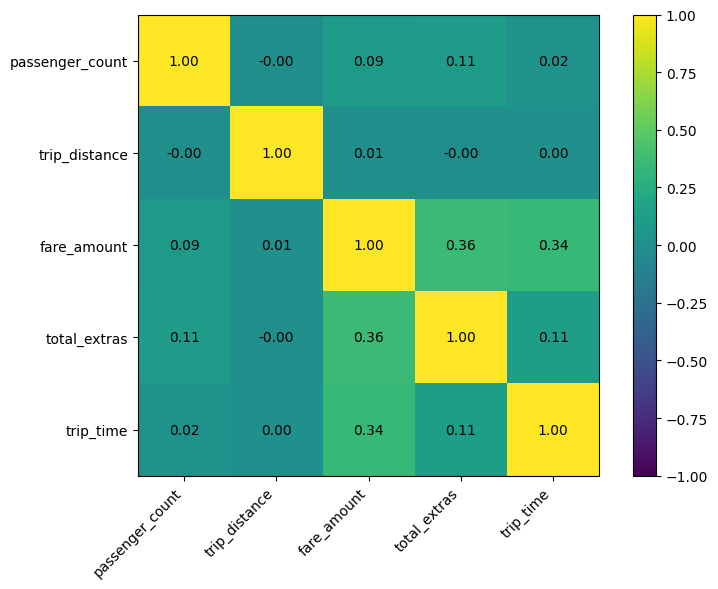

In [21]:
prefix = "yellow_tripdata_"
ext = "parquet"
path = f"data/{prefix}2025-08.{ext}"
stats(process_df(pd.read_parquet(path)))

Widać, że w praktycznie wszystkich plikach występują _dziwne_ wartości minimalne, tj.:
- `passenger_count` = 0
- `trip_distance` = 0
- `fare_amount` = 0

Zakładam, że mogą one oznaczać jedne z kilku rzeczy:
- Pasażer zamówił taksówkę i nie przyszedł
- Dane zostały niewłaściwie zebrane
- Płatność się niepoprawnie zarejestrowała

Co innego jest w przypadku wartości maksymalnych
- `passenger_count` = 9 - to akurat jest w porządku, może być tak, że jakaś specjalna taryfa ma 9 miejsc
- `trip_distance` w dziesiątkach tysięcy mil - raczej jest to jakiś błąd, tym bardziej że taksówki mają pracować jedynie w obrębie Nowego Jorku
- `fare_amount` w dziesiątkach tysięcy - również zakładam, że jest błędne

Widać również inne elementy stałe - podobne korelacje między danymi cechami, można to zinterpretować w taki sposób, że dane mają w większości podobne struktury. Dodatkowo - zapewne taksówkarze pracują w jakiś mniej więcej schematyczny sposób.

Początkowo korzystałem z takiego kodu:

In [ ]:
print("Łączenie ramek...")

prefix = "yellow_tripdata_"
ext = "parquet"

months:list[str] = [
    '2024-09', '2024-10', '2024-11', '2024-12',
    '2025-01', '2025-02', '2025-03', '2025-04',
    '2025-05', '2025-06', '2025-07', '2025-08'
]

df = pd.concat(
    (pd.read_parquet(f"data/{prefix}{m}.{ext}") for m in months),
    ignore_index=True
)

print("Złączono!")

df = process_df(df)
stats(df)

result = train_test(df, LGBMRegressor())

print('RMSE', result[0])
print('MAE', result[1])
print('R2', result[2])

Ale nie jest on możliwy do wykonania, ze względu na ograniczenia sprzętowe - 8 GB pamięci RAM daje `MemoryError` przy każdej próbie wywołania - transformacji jest po prostu bardzo dużo.

Alternatywy są dwie:
- **Zostając przy Pandas**: przetwarzać dane partiami, ewentualnie zapisać duży plik `.parquet` na dysk i potem pracować chunkami na nim
- **Zmiana biblioteki**: `polars` czy `dask` podobno radzą sobie dużo lepiej ze zbiorami typu *big-data*

Ze względu na charakter uczelniany projektu, zastosuję podejście mieszane:
1. Zmienię bibliotekę na `polars`
2. Jeżeli to w dalszym ciągu nie pomoże, to wówczas zastosuję przetwarzanie partiami jeszcze z użyciem `polars`

In [22]:
import polars as pl
import pandas as pd
import numpy as np
import lightgbm as lgb
import os
import pyarrow.parquet as pq
from pathlib import Path
from sklearn.metrics import mean_squared_error
import math

Przetworzenie pojedyńczego rekordu sprowadzi się zatem do:
- Sprawdzenia czasu przejazdu w sekundach (`trip_time`)
- Ujednoliceniu typów danych
- Usunięcie rekordów z bardzo odstającymi wartościami (outliers)
- Połączeniu kolumn z opłatami dodatkowymi

In [ ]:
def process_lf (lf: pl.LazyFrame):
    fill_values = {
        'passenger_count': 1,
        'RatecodeID': 1,
        'store_and_fwd_flag': 'N',
        'congestion_surcharge': 0,
        'Airport_fee': 0,
        'cbd_congestion_fee': 0
    }

    filter_cols = ['extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee', 'fare_amount', "cbd_congestion_fee"]
    total_cols = ['extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee', "cbd_congestion_fee"]
    int_cols = ["PULocationID", "DOLocationID", "RatecodeID", "passenger_count"]
    float_cols = ["trip_time", "total_extras", "trip_distance", "fare_amount", "cbd_congestion_fee"]
    drop_cols = ["VendorID", "store_and_fwd_flag", "payment_type", "tip_amount", "total_amount", "cbd_congestion_fee"]

    print("\tWypełnianie NA")
    lf = lf.fill_null(fill_values)

    print("\tFiltrowanie")
    for col in filter_cols:
        lf = lf.filter(pl.col(col) >= 0)

    print("\tTotal extras")

    existing_cols = lf.collect_schema().names()
    valid_total_cols = [c for c in total_cols if c in existing_cols]

    lf = lf.with_columns(
        pl.sum_horizontal(*(pl.col(c).cast(pl.Float64) for c in valid_total_cols)).alias("total_extras")
    )

    lf = (
        lf.with_columns([
            pl.col("tpep_pickup_datetime").str.strptime(pl.Datetime("ns")),
            pl.col("tpep_dropoff_datetime").str.strptime(pl.Datetime("ns")),
        ])
        .with_columns(
            trip_time = (pl.col("tpep_dropoff_datetime") - pl.col("tpep_pickup_datetime")).dt.total_seconds()
        )
        .drop(["tpep_pickup_datetime", "tpep_dropoff_datetime"])
        .filter(pl.col("trip_time") >= 0)
    )

    print("\tRzutowanie na Int64")
    lf = lf.with_columns([pl.col(c).cast(pl.Int64) for c in int_cols])
    print("\tRzutowanie na Float64")
    lf = lf.with_columns([pl.col(c).cast(pl.Float64) for c in float_cols])

    print("\tUsuwanie kolumn")
    lf = lf.drop(drop_cols)

    print("\tEncoding kategoryczny")
    lf = lf.with_columns([
        pl.col("RatecodeID").cast(pl.Categorical),
        pl.col("PULocationID").cast(pl.Categorical),
        pl.col("DOLocationID").cast(pl.Categorical),
    ])

    return lf

Funkcja dodająca kolumnę `cbd_congestion_fee` do pliku, jeżeli takowy go nie posiada (innego rozwiązania niestety nie jestem w stanie zrobić...):

In [11]:
def modify_file(month, prefix="yellow_tripdata_"):
    path = f"data/{prefix}{month}.parquet"
    tmp_path = path + ".tmp"

    print(f"Modyfikowanie pliku {path}")

    df = pl.read_parquet(path)

    df = df.with_columns([
        pl.col("tpep_pickup_datetime").cast(pl.Utf8),
        pl.col("tpep_dropoff_datetime").cast(pl.Utf8),
    ])

    if "cbd_congestion_fee" not in df.columns:
        df = df.with_columns(pl.lit(0.0).cast(pl.Float64).alias("cbd_congestion_fee"))

    df.write_parquet(tmp_path)
    os.replace(tmp_path, path)

Funkcja wczytująca pliki `.parquet` w trybie Lazy - bez ładowania na raz do pamięci.

In [ ]:
def load_all_parquet_lazy(months, prefix="yellow_tripdata_"):
    lfs = []

    for m in months:
        lf = pl.scan_parquet(f"data/{prefix}{m}.parquet")
        lfs.append(lf)

    return pl.concat(lfs)

Budowanie ostatecznego zbioru danych w trybie streaming - strumieniowo, a nie *naraz*.

In [ ]:
def build_final_dataset():
    months = [
        '2024-09', '2024-10', '2024-11', '2024-12',
        '2025-01', '2025-02', '2025-03', '2025-04',
        '2025-05', '2025-06', '2025-07', '2025-08'
    ]

    print("Ładowanie plików...")
    lf = load_all_parquet_lazy(months=months)

    print("Przetwarzanie plików...")
    lf = process_lf(lf)

    print("Zapisywanie pliku...")
    lf.sink_parquet("processed.parquet", compression="snappy", maintain_order=False)

    print("Zapisano!")

Funkcja do trenowania modelu `LightBGM`:

In [ ]:
def train_lgbm_from_parquet(params={}):
    model = lgb.LGBMRegressor(**params)    
    parquet = pq.ParquetFile("processed.parquet")

    first = True

    for i in range(parquet.num_row_groups):
        batch = parquet.read_row_group(i)
        df = pl.from_arrow(batch)

        X = df.drop("fare_amount").to_numpy()
        y = df["fare_amount"].to_numpy()

        if first:
            model.fit(X, y)
            first = False
        else:
            model.fit(X, y, init_model=model)

    return model

Dodanie odpowiednich informacji do wszystkich plików:

In [ ]:
months = [
    '2024-09', '2024-10', '2024-11', '2024-12',
    '2025-01', '2025-02', '2025-03', '2025-04',
    '2025-05', '2025-06', '2025-07', '2025-08'
]

for m in months:
    modify_file(m)

Modyfikowanie pliku data/yellow_tripdata_2024-09.parquet
Modyfikowanie pliku data/yellow_tripdata_2024-10.parquet
Modyfikowanie pliku data/yellow_tripdata_2024-11.parquet
Modyfikowanie pliku data/yellow_tripdata_2024-12.parquet
Modyfikowanie pliku data/yellow_tripdata_2025-01.parquet
Modyfikowanie pliku data/yellow_tripdata_2025-02.parquet
Modyfikowanie pliku data/yellow_tripdata_2025-03.parquet
Modyfikowanie pliku data/yellow_tripdata_2025-04.parquet
Modyfikowanie pliku data/yellow_tripdata_2025-05.parquet
Modyfikowanie pliku data/yellow_tripdata_2025-06.parquet
Modyfikowanie pliku data/yellow_tripdata_2025-07.parquet
Modyfikowanie pliku data/yellow_tripdata_2025-08.parquet


Sprawdzenie schematu każdego z plików - jeżeli będą różne, to zapis nie będzie możliwy.

In [ ]:
prefix = "yellow_tripdata_"

rows = []

for m in months:
    schema = pl.read_parquet(f"data/{prefix}{m}.parquet").schema
    schema_dict = dict(schema)
    schema_dict["file"] = m
    rows.append(schema_dict)

df_schema = pl.DataFrame(rows)
df_schema = df_schema.select(["file"] + [c for c in df_schema.columns if c != "file"])

df_pd:pd.DataFrame = df_schema.to_pandas()

with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.width", None):
    display(df_pd)

,file,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,2024-09,Int32,String,String,Int64,Float64,Int64,String,Int32,Int32,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2024-10,Int32,String,String,Int64,Float64,Int64,String,Int32,Int32,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
2,2024-11,Int32,String,String,Int64,Float64,Int64,String,Int32,Int32,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
3,2024-12,Int32,String,String,Int64,Float64,Int64,String,Int32,Int32,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
4,2025-01,Int32,String,String,Int64,Float64,Int64,String,Int32,Int32,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
5,2025-02,Int32,String,String,Int64,Float64,Int64,String,Int32,Int32,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
6,2025-03,Int32,String,String,Int64,Float64,Int64,String,Int32,Int32,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
7,2025-04,Int32,String,String,Int64,Float64,Int64,String,Int32,Int32,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
8,2025-05,Int32,String,String,Int64,Float64,Int64,String,Int32,Int32,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
9,2025-06,Int32,String,String,Int64,Float64,Int64,String,Int32,Int32,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64


Sprawdzenie ilości cech w każdym z plików (muszą być równe!):

In [ ]:
prefix = "yellow_tripdata_"
rows = []

for m in months:
    path = f"data/{prefix}{m}.parquet"
    print(path, end=": ")
    pf = pq.ParquetFile(path)
    schema = pf.schema_arrow
    print(len(schema))


data/yellow_tripdata_2024-09.parquet: 20
data/yellow_tripdata_2024-10.parquet: 20
data/yellow_tripdata_2024-11.parquet: 20
data/yellow_tripdata_2024-12.parquet: 20
data/yellow_tripdata_2025-01.parquet: 20
data/yellow_tripdata_2025-02.parquet: 20
data/yellow_tripdata_2025-03.parquet: 20
data/yellow_tripdata_2025-04.parquet: 20
data/yellow_tripdata_2025-05.parquet: 20
data/yellow_tripdata_2025-06.parquet: 20
data/yellow_tripdata_2025-07.parquet: 20
data/yellow_tripdata_2025-08.parquet: 20


Kolejna próba stworzenia dużego zbioru:

In [ ]:
build_final_dataset()

Ładowanie plików...
Przetwarzanie plików...
	Dodawanie kolumny
	Wypełnianie NA
	Filtrowanie
	Total extras
	Rzutowanie na Int64
	Rzutowanie na Float64
	Usuwanie kolumn
	Encoding kategoryczny
Zapisywanie pliku...


InvalidOperationError: must specify one field in the struct

Niestety, w tym podejściu wystąpił inny problem: Pliki parquet mają niewłaściwe schematy - w przypadku `LazyFrame` biblioteka próbuje ustalić schemat na poziomie łączenia, co powoduje duże problemy w przypadku pracy z typami danych jak `Datetime`.

Spróbuję zatem zrobić inaczej - przeprocesowane, osobne pliki.

Funkcja na bazie `process_lf`, która przetwarza wszystko w pamięci, a nie w trybie `lazy`:

In [9]:
def process_df (df: pl.DataFrame):
    fill_values = {
        'passenger_count': 1,
        'RatecodeID': 1,
        'store_and_fwd_flag': 'N',
        'congestion_surcharge': 0,
        'Airport_fee': 0,
        'cbd_congestion_fee': 0
    }

    filter_cols = ['extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee', 'fare_amount', "cbd_congestion_fee"]
    total_cols = ['extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee', "cbd_congestion_fee"]
    int_cols = ["PULocationID", "DOLocationID", "RatecodeID", "passenger_count"]
    float_cols = ["trip_time", "total_extras", "trip_distance", "fare_amount"]
    drop_cols = ["VendorID", "store_and_fwd_flag", "payment_type", "tip_amount", "total_amount"]

    print("\tWypełnianie NA")
    for col, val in fill_values.items():
        if col in df.columns:
            df = df.with_columns(pl.col(col).fill_null(val))

    print("\tFiltrowanie")
    for col in filter_cols:
        df = df.filter(pl.col(col) >= 0)

    print("\tTotal extras")
    existing_cols = df.collect_schema().names()
    valid_total_cols = [c for c in total_cols if c in existing_cols]

    df = df.with_columns(
        pl.sum_horizontal(*(pl.col(c).cast(pl.Float64) for c in valid_total_cols)).alias("total_extras")
    ).drop(valid_total_cols)

    df = (
        df.with_columns([
            pl.col("tpep_pickup_datetime").str.strptime(pl.Datetime("ns")),
            pl.col("tpep_dropoff_datetime").str.strptime(pl.Datetime("ns")),
        ])
        .with_columns(
            trip_time = (pl.col("tpep_dropoff_datetime") - pl.col("tpep_pickup_datetime")).dt.total_seconds()
        )
        .drop(["tpep_pickup_datetime", "tpep_dropoff_datetime"])
        .filter(pl.col("trip_time") >= 0)
    )

    print("\tRzutowanie na Int64")
    df = df.with_columns([pl.col(c).cast(pl.Int64) for c in int_cols])
    print("\tRzutowanie na Float64")
    df = df.with_columns([pl.col(c).cast(pl.Float64) for c in float_cols])

    print("\tUsuwanie kolumn")
    df = df.drop(drop_cols)

    return df

Funkcja procesująca jeden plik:

In [5]:
def process_file(input_path: str):
    input_path = Path(input_path)
    filename_stem = input_path.stem
    output_path = f"processed/{filename_stem}-processed.parquet"

    print(f"Przetwarzanie: {input_path} => {output_path}")

    df = pl.read_parquet(input_path)
    
    print("Podgląd pliku")
    display(df.head())

    df_processed = process_df(df)
    df_processed.write_parquet(output_path)

    display(df_processed.head())

    print(f"Zapisano: {output_path}")

Procesowanie wszystkich plików:

In [ ]:
prefix = "yellow_tripdata_"

months = [
    '2024-09', '2024-10', '2024-11', '2024-12',
    '2025-01', '2025-02', '2025-03', '2025-04',
    '2025-05', '2025-06', '2025-07', '2025-08'
]

for m in months:
    path = f"data/{prefix}{m}.parquet"
    process_file(path)

Przetwarzanie: data\yellow_tripdata_2024-09.parquet => processed/yellow_tripdata_2024-09-processed.parquet
Podgląd pliku


VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
i32,str,str,i64,f64,i64,str,i32,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,"""2024-09-01 00:05:51.000000000""","""2024-09-01 00:45:03.000000000""",1,9.8,1,"""N""",138,48,1,47.8,10.25,0.5,13.3,6.94,1.0,79.79,2.5,1.75,0.0
1,"""2024-09-01 00:59:35.000000000""","""2024-09-01 01:03:43.000000000""",1,0.5,1,"""N""",140,141,1,5.1,3.5,0.5,3.0,0.0,1.0,13.1,2.5,0.0,0.0
2,"""2024-09-01 00:25:00.000000000""","""2024-09-01 00:34:37.000000000""",2,2.29,1,"""N""",238,152,2,13.5,1.0,0.5,0.0,0.0,1.0,16.0,0.0,0.0,0.0
2,"""2024-09-01 00:31:00.000000000""","""2024-09-01 00:46:52.000000000""",1,5.2,1,"""N""",93,130,1,24.7,1.0,0.5,4.55,0.0,1.0,31.75,0.0,0.0,0.0
2,"""2024-09-01 00:11:57.000000000""","""2024-09-01 00:30:41.000000000""",2,2.26,1,"""N""",79,231,1,17.0,1.0,0.5,4.4,0.0,1.0,26.4,2.5,0.0,0.0


	Wypełnianie NA
	Filtrowanie
	Total extras
	Rzutowanie na Int64
	Rzutowanie na Float64
	Usuwanie kolumn


passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,total_extras,trip_time
i64,f64,i64,i64,i64,f64,f64,f64
1,9.8,1,138,48,47.8,22.94,2352.0
1,0.5,1,140,141,5.1,7.5,248.0
2,2.29,1,238,152,13.5,2.5,577.0
1,5.2,1,93,130,24.7,2.5,952.0
2,2.26,1,79,231,17.0,5.0,1124.0


Zapisano: processed/yellow_tripdata_2024-09-processed.parquet
Przetwarzanie: data\yellow_tripdata_2024-10.parquet => processed/yellow_tripdata_2024-10-processed.parquet
Podgląd pliku


VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
i32,str,str,i64,f64,i64,str,i32,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2,"""2024-10-01 00:30:44.000000000""","""2024-10-01 00:48:26.000000000""",1,3.0,1,"""N""",162,246,1,18.4,1.0,0.5,1.5,0.0,1.0,24.9,2.5,0.0,0.0
1,"""2024-10-01 00:12:20.000000000""","""2024-10-01 00:25:25.000000000""",1,2.2,1,"""N""",48,236,1,14.2,3.5,0.5,3.8,0.0,1.0,23.0,2.5,0.0,0.0
1,"""2024-10-01 00:04:46.000000000""","""2024-10-01 00:13:52.000000000""",1,2.7,1,"""N""",142,24,1,13.5,3.5,0.5,3.7,0.0,1.0,22.2,2.5,0.0,0.0
1,"""2024-10-01 00:12:10.000000000""","""2024-10-01 00:23:01.000000000""",1,3.1,1,"""N""",233,75,1,14.2,3.5,0.5,2.0,0.0,1.0,21.2,2.5,0.0,0.0
1,"""2024-10-01 00:30:22.000000000""","""2024-10-01 00:30:39.000000000""",1,0.0,1,"""N""",262,262,3,3.0,3.5,0.5,0.0,0.0,1.0,8.0,2.5,0.0,0.0


	Wypełnianie NA
	Filtrowanie
	Total extras
	Rzutowanie na Int64
	Rzutowanie na Float64
	Usuwanie kolumn


passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,total_extras,trip_time
i64,f64,i64,i64,i64,f64,f64,f64
1,3.0,1,162,246,18.4,5.0,1062.0
1,2.2,1,48,236,14.2,7.5,785.0
1,2.7,1,142,24,13.5,7.5,546.0
1,3.1,1,233,75,14.2,7.5,651.0
1,0.0,1,262,262,3.0,7.5,17.0


Zapisano: processed/yellow_tripdata_2024-10-processed.parquet
Przetwarzanie: data\yellow_tripdata_2024-11.parquet => processed/yellow_tripdata_2024-11-processed.parquet
Podgląd pliku


VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
i32,str,str,i64,f64,i64,str,i32,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2,"""2024-11-01 00:46:24.000000000""","""2024-11-01 00:57:17.000000000""",1,1.93,1,"""N""",239,262,2,-12.8,-1.0,-0.5,0.0,0.0,-1.0,-17.8,-2.5,0.0,0.0
2,"""2024-11-01 00:46:24.000000000""","""2024-11-01 00:57:17.000000000""",1,1.93,1,"""N""",239,263,2,12.8,1.0,0.5,0.0,0.0,1.0,17.8,2.5,0.0,0.0
1,"""2024-11-01 00:37:36.000000000""","""2024-11-01 01:28:36.000000000""",1,34.3,5,"""N""",219,265,1,259.0,0.0,0.0,15.0,0.0,1.0,275.0,0.0,0.0,0.0
2,"""2024-11-01 00:12:55.000000000""","""2024-11-01 00:22:17.000000000""",2,0.93,1,"""N""",186,107,1,10.0,1.0,0.5,1.0,0.0,1.0,16.0,2.5,0.0,0.0
2,"""2024-11-01 00:54:45.000000000""","""2024-11-01 00:59:47.000000000""",1,0.38,1,"""N""",79,79,1,6.5,1.0,0.5,1.0,0.0,1.0,12.5,2.5,0.0,0.0


	Wypełnianie NA
	Filtrowanie
	Total extras
	Rzutowanie na Int64
	Rzutowanie na Float64
	Usuwanie kolumn


passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,total_extras,trip_time
i64,f64,i64,i64,i64,f64,f64,f64
1,1.93,1,239,263,12.8,5.0,653.0
1,34.3,5,219,265,259.0,1.0,3060.0
2,0.93,1,186,107,10.0,5.0,562.0
1,0.38,1,79,79,6.5,5.0,302.0
1,0.48,1,237,236,5.1,5.0,148.0


Zapisano: processed/yellow_tripdata_2024-11-processed.parquet
Przetwarzanie: data\yellow_tripdata_2024-12.parquet => processed/yellow_tripdata_2024-12-processed.parquet
Podgląd pliku


VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
i32,str,str,i64,f64,i64,str,i32,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2,"""2024-12-01 00:12:27.000000000""","""2024-12-01 00:31:12.000000000""",1,9.76,1,"""N""",138,33,1,38.0,6.0,0.5,4.72,0.0,1.0,51.97,0.0,1.75,0.0
2,"""2024-11-30 23:56:04.000000000""","""2024-12-01 00:28:15.000000000""",1,7.62,1,"""N""",158,42,1,37.3,1.0,0.5,8.46,0.0,1.0,50.76,2.5,0.0,0.0
2,"""2024-12-01 00:50:35.000000000""","""2024-12-01 01:24:46.000000000""",4,20.07,2,"""N""",132,236,2,70.0,0.0,0.5,0.0,6.94,1.0,82.69,2.5,1.75,0.0
2,"""2024-12-01 00:18:16.000000000""","""2024-12-01 00:33:16.000000000""",3,2.34,1,"""N""",142,186,1,15.6,1.0,0.5,4.12,0.0,1.0,24.72,2.5,0.0,0.0
2,"""2024-12-01 00:56:13.000000000""","""2024-12-01 01:18:25.000000000""",1,5.05,1,"""N""",107,80,1,26.8,1.0,0.5,5.0,0.0,1.0,36.8,2.5,0.0,0.0


	Wypełnianie NA
	Filtrowanie
	Total extras
	Rzutowanie na Int64
	Rzutowanie na Float64
	Usuwanie kolumn


passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,total_extras,trip_time
i64,f64,i64,i64,i64,f64,f64,f64
1,9.76,1,138,33,38.0,9.25,1125.0
1,7.62,1,158,42,37.3,5.0,1931.0
4,20.07,2,132,236,70.0,12.69,2051.0
3,2.34,1,142,186,15.6,5.0,900.0
1,5.05,1,107,80,26.8,5.0,1332.0


Zapisano: processed/yellow_tripdata_2024-12-processed.parquet
Przetwarzanie: data\yellow_tripdata_2025-01.parquet => processed/yellow_tripdata_2025-01-processed.parquet
Podgląd pliku


VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
i32,str,str,i64,f64,i64,str,i32,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,"""2025-01-01 00:18:38.000000000""","""2025-01-01 00:26:59.000000000""",1,1.6,1,"""N""",229,237,1,10.0,3.5,0.5,3.0,0.0,1.0,18.0,2.5,0.0,0.0
1,"""2025-01-01 00:32:40.000000000""","""2025-01-01 00:35:13.000000000""",1,0.5,1,"""N""",236,237,1,5.1,3.5,0.5,2.02,0.0,1.0,12.12,2.5,0.0,0.0
1,"""2025-01-01 00:44:04.000000000""","""2025-01-01 00:46:01.000000000""",1,0.6,1,"""N""",141,141,1,5.1,3.5,0.5,2.0,0.0,1.0,12.1,2.5,0.0,0.0
2,"""2025-01-01 00:14:27.000000000""","""2025-01-01 00:20:01.000000000""",3,0.52,1,"""N""",244,244,2,7.2,1.0,0.5,0.0,0.0,1.0,9.7,0.0,0.0,0.0
2,"""2025-01-01 00:21:34.000000000""","""2025-01-01 00:25:06.000000000""",3,0.66,1,"""N""",244,116,2,5.8,1.0,0.5,0.0,0.0,1.0,8.3,0.0,0.0,0.0


	Wypełnianie NA
	Filtrowanie
	Total extras
	Rzutowanie na Int64
	Rzutowanie na Float64
	Usuwanie kolumn


passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,total_extras,trip_time
i64,f64,i64,i64,i64,f64,f64,f64
1,1.6,1,229,237,10.0,7.5,501.0
1,0.5,1,236,237,5.1,7.5,153.0
1,0.6,1,141,141,5.1,7.5,117.0
3,0.52,1,244,244,7.2,2.5,334.0
3,0.66,1,244,116,5.8,2.5,212.0


Zapisano: processed/yellow_tripdata_2025-01-processed.parquet
Przetwarzanie: data\yellow_tripdata_2025-02.parquet => processed/yellow_tripdata_2025-02-processed.parquet
Podgląd pliku


VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
i32,str,str,i64,f64,i64,str,i32,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2,"""2025-02-01 00:12:18.000000000""","""2025-02-01 00:32:33.000000000""",3,3.12,1,"""N""",246,79,1,19.8,1.0,0.5,5.11,0.0,1.0,30.66,2.5,0.0,0.75
2,"""2025-02-01 00:40:04.000000000""","""2025-02-01 00:49:15.000000000""",1,1.4,1,"""N""",114,79,1,10.0,1.0,0.5,3.15,0.0,1.0,18.9,2.5,0.0,0.75
1,"""2025-02-01 00:06:09.000000000""","""2025-02-01 00:11:51.000000000""",0,0.4,1,"""N""",211,144,1,6.5,4.25,0.5,1.0,0.0,1.0,13.25,2.5,0.0,0.75
1,"""2025-02-01 00:15:13.000000000""","""2025-02-01 00:20:19.000000000""",0,0.7,1,"""N""",113,249,1,7.2,4.25,0.5,2.0,0.0,1.0,14.95,2.5,0.0,0.75
2,"""2025-02-01 00:02:52.000000000""","""2025-02-01 00:20:25.000000000""",1,4.19,1,"""N""",113,263,1,19.8,1.0,0.5,5.11,0.0,1.0,30.66,2.5,0.0,0.75


	Wypełnianie NA
	Filtrowanie
	Total extras
	Rzutowanie na Int64
	Rzutowanie na Float64
	Usuwanie kolumn


passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,total_extras,trip_time
i64,f64,i64,i64,i64,f64,f64,f64
3,3.12,1,246,79,19.8,5.75,1215.0
1,1.4,1,114,79,10.0,5.75,551.0
0,0.4,1,211,144,6.5,9.0,342.0
0,0.7,1,113,249,7.2,9.0,306.0
1,4.19,1,113,263,19.8,5.75,1053.0


Zapisano: processed/yellow_tripdata_2025-02-processed.parquet
Przetwarzanie: data\yellow_tripdata_2025-03.parquet => processed/yellow_tripdata_2025-03-processed.parquet
Podgląd pliku


VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
i32,str,str,i64,f64,i64,str,i32,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,"""2025-03-01 00:17:16.000000000""","""2025-03-01 00:25:52.000000000""",1,0.9,1,"""N""",140,236,1,7.9,3.5,0.5,2.6,0.0,1.0,15.5,2.5,0.0,0.0
1,"""2025-03-01 00:37:38.000000000""","""2025-03-01 00:43:51.000000000""",1,0.6,1,"""N""",140,262,1,6.5,3.5,0.5,2.3,0.0,1.0,13.8,2.5,0.0,0.0
2,"""2025-03-01 00:24:35.000000000""","""2025-03-01 00:39:49.000000000""",1,1.94,1,"""N""",161,68,1,14.9,1.0,0.5,5.16,0.0,1.0,25.81,2.5,0.0,0.75
2,"""2025-03-01 00:56:16.000000000""","""2025-03-01 01:01:35.000000000""",2,0.95,1,"""N""",231,13,1,7.2,1.0,0.5,2.59,0.0,1.0,15.54,2.5,0.0,0.75
1,"""2025-03-01 00:01:44.000000000""","""2025-03-01 00:10:00.000000000""",1,1.5,1,"""N""",163,236,1,8.6,4.25,0.5,2.85,0.0,1.0,17.2,2.5,0.0,0.75


	Wypełnianie NA
	Filtrowanie
	Total extras
	Rzutowanie na Int64
	Rzutowanie na Float64
	Usuwanie kolumn


passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,total_extras,trip_time
i64,f64,i64,i64,i64,f64,f64,f64
1,0.9,1,140,236,7.9,7.5,516.0
1,0.6,1,140,262,6.5,7.5,373.0
1,1.94,1,161,68,14.9,5.75,914.0
2,0.95,1,231,13,7.2,5.75,319.0
1,1.5,1,163,236,8.6,9.0,496.0


Zapisano: processed/yellow_tripdata_2025-03-processed.parquet
Przetwarzanie: data\yellow_tripdata_2025-04.parquet => processed/yellow_tripdata_2025-04-processed.parquet
Podgląd pliku


VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
i32,str,str,i64,f64,i64,str,i32,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,"""2025-04-01 00:47:06.000000000""","""2025-04-01 01:13:25.000000000""",1,9.5,1,"""N""",138,230,1,38.7,11.0,0.5,11.65,6.94,1.0,69.79,2.5,1.75,0.75
2,"""2025-04-01 00:27:35.000000000""","""2025-04-01 00:38:19.000000000""",2,3.77,1,"""N""",138,92,1,17.0,6.0,0.5,4.9,0.0,1.0,31.15,0.0,1.75,0.0
2,"""2025-04-01 00:24:07.000000000""","""2025-04-01 00:35:12.000000000""",1,5.41,1,"""N""",132,130,1,22.6,1.0,0.5,5.37,0.0,1.0,32.22,0.0,1.75,0.0
1,"""2025-04-01 00:56:30.000000000""","""2025-04-01 01:00:49.000000000""",2,0.6,1,"""N""",79,4,1,6.5,4.25,0.5,2.45,0.0,1.0,14.7,2.5,0.0,0.75
2,"""2025-04-01 00:00:17.000000000""","""2025-04-01 00:16:19.000000000""",1,0.43,1,"""N""",161,229,2,4.4,1.0,0.5,0.0,0.0,1.0,10.15,2.5,0.0,0.75


	Wypełnianie NA
	Filtrowanie
	Total extras
	Rzutowanie na Int64
	Rzutowanie na Float64
	Usuwanie kolumn


passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,total_extras,trip_time
i64,f64,i64,i64,i64,f64,f64,f64
1,9.5,1,138,230,38.7,24.44,1579.0
2,3.77,1,138,92,17.0,9.25,644.0
1,5.41,1,132,130,22.6,4.25,665.0
2,0.6,1,79,4,6.5,9.0,259.0
1,0.43,1,161,229,4.4,5.75,962.0


Zapisano: processed/yellow_tripdata_2025-04-processed.parquet
Przetwarzanie: data\yellow_tripdata_2025-05.parquet => processed/yellow_tripdata_2025-05-processed.parquet
Podgląd pliku


VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
i32,str,str,i64,f64,i64,str,i32,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,"""2025-05-01 00:07:06.000000000""","""2025-05-01 00:24:15.000000000""",1,3.7,1,"""N""",140,202,1,18.4,4.25,0.5,4.85,0.0,1.0,29.0,2.5,0.0,0.75
2,"""2025-05-01 00:07:44.000000000""","""2025-05-01 00:14:27.000000000""",1,1.03,1,"""N""",234,161,1,8.6,1.0,0.5,4.3,0.0,1.0,18.65,2.5,0.0,0.75
2,"""2025-05-01 00:15:56.000000000""","""2025-05-01 00:23:53.000000000""",1,1.57,1,"""N""",161,234,2,10.0,1.0,0.5,0.0,0.0,1.0,15.75,2.5,0.0,0.75
2,"""2025-05-01 00:00:09.000000000""","""2025-05-01 00:25:29.000000000""",1,9.48,1,"""N""",138,90,1,40.8,6.0,0.5,11.7,6.94,1.0,71.94,2.5,1.75,0.75
2,"""2025-05-01 00:45:07.000000000""","""2025-05-01 00:52:45.000000000""",1,1.8,1,"""N""",90,231,1,10.0,1.0,0.5,1.5,0.0,1.0,17.25,2.5,0.0,0.75


	Wypełnianie NA
	Filtrowanie
	Total extras
	Rzutowanie na Int64
	Rzutowanie na Float64
	Usuwanie kolumn


passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,total_extras,trip_time
i64,f64,i64,i64,i64,f64,f64,f64
1,3.7,1,140,202,18.4,9.0,1029.0
1,1.03,1,234,161,8.6,5.75,403.0
1,1.57,1,161,234,10.0,5.75,477.0
1,9.48,1,138,90,40.8,19.44,1520.0
1,1.8,1,90,231,10.0,5.75,458.0


Zapisano: processed/yellow_tripdata_2025-05-processed.parquet
Przetwarzanie: data\yellow_tripdata_2025-06.parquet => processed/yellow_tripdata_2025-06-processed.parquet
Podgląd pliku


VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
i32,str,str,i64,f64,i64,str,i32,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,"""2025-06-01 00:02:50.000000000""","""2025-06-01 00:39:51.000000000""",1,10.0,1,"""N""",138,50,1,47.8,11.0,0.5,20.15,6.94,1.0,87.39,2.5,1.75,0.75
2,"""2025-06-01 00:11:27.000000000""","""2025-06-01 00:35:35.000000000""",1,3.93,1,"""N""",158,237,1,24.7,1.0,0.5,6.09,0.0,1.0,36.54,2.5,0.0,0.75
1,"""2025-06-01 00:43:47.000000000""","""2025-06-01 00:49:16.000000000""",0,0.7,1,"""N""",230,163,1,7.2,4.25,0.5,2.59,0.0,1.0,15.54,2.5,0.0,0.75
1,"""2025-06-01 00:01:15.000000000""","""2025-06-01 00:42:16.000000000""",1,17.0,2,"""N""",132,232,1,70.0,3.25,0.5,5.0,0.0,1.0,79.75,2.5,0.0,0.75
7,"""2025-06-01 00:16:32.000000000""","""2025-06-01 00:16:32.000000000""",1,2.22,1,"""N""",48,234,1,20.5,0.0,0.5,5.25,0.0,1.0,31.5,2.5,0.0,0.75


	Wypełnianie NA
	Filtrowanie
	Total extras
	Rzutowanie na Int64
	Rzutowanie na Float64
	Usuwanie kolumn


passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,total_extras,trip_time
i64,f64,i64,i64,i64,f64,f64,f64
1,10.0,1,138,50,47.8,24.44,2221.0
1,3.93,1,158,237,24.7,5.75,1448.0
0,0.7,1,230,163,7.2,9.0,329.0
1,17.0,2,132,232,70.0,8.0,2461.0
1,2.22,1,48,234,20.5,4.75,0.0


Zapisano: processed/yellow_tripdata_2025-06-processed.parquet
Przetwarzanie: data\yellow_tripdata_2025-07.parquet => processed/yellow_tripdata_2025-07-processed.parquet
Podgląd pliku


VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
i32,str,str,i64,f64,i64,str,i32,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,"""2025-07-01 00:29:37.000000000""","""2025-07-01 00:45:30.000000000""",1,7.3,1,"""N""",138,74,1,29.6,7.75,0.5,9.0,6.94,1.0,54.79,0.0,1.75,0.0
1,"""2025-07-01 00:23:28.000000000""","""2025-07-01 01:07:44.000000000""",1,17.7,2,"""N""",132,142,1,70.0,4.25,0.5,5.0,0.0,1.0,80.75,2.5,1.75,0.0
2,"""2025-07-01 00:53:50.000000000""","""2025-07-01 01:27:12.000000000""",1,9.98,1,"""N""",138,48,1,43.6,6.0,0.5,10.87,0.0,1.0,66.97,2.5,1.75,0.75
2,"""2025-07-01 00:58:49.000000000""","""2025-07-01 01:15:55.000000000""",1,10.27,1,"""N""",138,229,1,38.7,6.0,0.5,14.1,6.94,1.0,72.24,2.5,1.75,0.75
2,"""2025-07-01 00:09:22.000000000""","""2025-07-01 00:23:54.000000000""",1,2.94,1,"""N""",211,97,1,17.0,1.0,0.5,3.0,0.0,1.0,25.75,2.5,0.0,0.75


	Wypełnianie NA
	Filtrowanie
	Total extras
	Rzutowanie na Int64
	Rzutowanie na Float64
	Usuwanie kolumn


passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,total_extras,trip_time
i64,f64,i64,i64,i64,f64,f64,f64
1,7.3,1,138,74,29.6,17.94,953.0
1,17.7,2,132,142,70.0,10.0,2656.0
1,9.98,1,138,48,43.6,12.5,2002.0
1,10.27,1,138,229,38.7,19.44,1026.0
1,2.94,1,211,97,17.0,5.75,872.0


Zapisano: processed/yellow_tripdata_2025-07-processed.parquet
Przetwarzanie: data\yellow_tripdata_2025-08.parquet => processed/yellow_tripdata_2025-08-processed.parquet
Podgląd pliku


VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
i32,str,str,i64,f64,i64,str,i32,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2,"""2025-08-01 00:52:23.000000000""","""2025-08-01 01:12:20.000000000""",1,8.44,1,"""N""",138,141,1,33.8,6.0,0.5,5.0,6.94,1.0,57.49,2.5,1.75,0.0
2,"""2025-08-01 00:03:01.000000000""","""2025-08-01 00:15:33.000000000""",2,4.98,1,"""N""",138,193,1,21.2,6.0,0.5,0.0,0.0,1.0,30.45,0.0,1.75,0.0
7,"""2025-08-01 00:24:38.000000000""","""2025-08-01 00:24:38.000000000""",2,1.89,1,"""N""",249,45,1,14.2,0.0,0.5,3.99,0.0,1.0,23.94,2.5,0.0,0.75
7,"""2025-08-01 00:48:19.000000000""","""2025-08-01 00:48:19.000000000""",1,2.35,1,"""N""",79,229,1,11.4,0.0,0.5,3.43,0.0,1.0,20.58,2.5,0.0,0.75
2,"""2025-08-01 00:25:34.000000000""","""2025-08-01 00:33:18.000000000""",1,2.14,1,"""N""",43,48,1,11.4,1.0,0.5,2.57,0.0,1.0,19.72,2.5,0.0,0.75


	Wypełnianie NA
	Filtrowanie
	Total extras
	Rzutowanie na Int64
	Rzutowanie na Float64
	Usuwanie kolumn


passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,total_extras,trip_time
i64,f64,i64,i64,i64,f64,f64,f64
1,8.44,1,138,141,33.8,18.69,1197.0
2,4.98,1,138,193,21.2,9.25,752.0
2,1.89,1,249,45,14.2,4.75,0.0
1,2.35,1,79,229,11.4,4.75,0.0
1,2.14,1,43,48,11.4,5.75,464.0


Zapisano: processed/yellow_tripdata_2025-08-processed.parquet


Uczenie na każdym z plików po kolei - pliki są czytate strumieniowo z z użyciem `lgb.Dataset()`, dzięki czemu nie _zabijają_ pamięci RAM.

In [3]:
files = [f"processed/yellow_tripdata_20{f}-processed.parquet" for f in ["24-09", "24-10", "24-11", "24-12",
                                                                        "25-01", "25-02", "25-03", "25-04",
                                                                        "25-05", "25-06", "25-07", "25-08"]]

y_name = "fare_amount"
model = None

params = {
    "objective": "regression",
    "metric": "rmse",

    "learning_rate": 0.03,
    "num_leaves": 64,
    "min_data_in_leaf": 100,

    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,

    "verbosity": -1,
    "seed": 42,
}


for path in files:
    print(f"Uczenie na pliku {path}")

    df = pl.read_parquet(path)
    X = df.drop(y_name).to_numpy()
    y = df[y_name].to_numpy()

    data = lgb.Dataset(X, label=y)

    model = lgb.train(
        params,
        data,
        num_boost_round=50,
        init_model=model
    )


Uczenie na pliku processed/yellow_tripdata_2024-09-processed.parquet
Uczenie na pliku processed/yellow_tripdata_2024-10-processed.parquet
Uczenie na pliku processed/yellow_tripdata_2024-11-processed.parquet
Uczenie na pliku processed/yellow_tripdata_2024-12-processed.parquet
Uczenie na pliku processed/yellow_tripdata_2025-01-processed.parquet
Uczenie na pliku processed/yellow_tripdata_2025-02-processed.parquet
Uczenie na pliku processed/yellow_tripdata_2025-03-processed.parquet
Uczenie na pliku processed/yellow_tripdata_2025-04-processed.parquet
Uczenie na pliku processed/yellow_tripdata_2025-05-processed.parquet
Uczenie na pliku processed/yellow_tripdata_2025-06-processed.parquet
Uczenie na pliku processed/yellow_tripdata_2025-07-processed.parquet
Uczenie na pliku processed/yellow_tripdata_2025-08-processed.parquet


In [14]:
model.save_model("lgb_fare.txt")

Czas uczenia wyniósł nieco ponad 5.5 minuty. Teraz można sprawdzić, jak dobrze model się wytrenował - z wykorzystaniem pliku `data/yellow_tripdata_2025-09.parquet`, czyli rzeczywistego, na którym będę chciał później pracować. Dla bezpieczeństwa natomiast, przeprocesuję plik jeszcze lokalnie.

In [12]:
modify_file("2025-09")
process_file("data/yellow_tripdata_2025-09.parquet")
path = "processed/yellow_tripdata_2025-09-processed.parquet"

Modyfikowanie pliku data/yellow_tripdata_2025-09.parquet
Przetwarzanie: data\yellow_tripdata_2025-09.parquet => processed/yellow_tripdata_2025-09-processed.parquet
Podgląd pliku


VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
i32,str,str,i64,f64,i64,str,i32,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2,"""2025-09-01 00:19:20.000000""","""2025-09-01 00:45:17.000000""",1,9.92,1,"""N""",138,114,1,42.9,6.0,0.5,10.73,0.0,1.0,66.13,2.5,1.75,0.75
2,"""2025-09-01 00:15:20.000000""","""2025-09-01 00:26:08.000000""",2,6.82,1,"""N""",93,157,1,26.8,1.0,0.5,5.86,0.0,1.0,35.16,0.0,0.0,0.0
2,"""2025-09-01 00:06:07.000000""","""2025-09-01 00:22:23.000000""",1,3.95,1,"""N""",68,13,1,19.8,1.0,0.5,5.11,0.0,1.0,30.66,2.5,0.0,0.75
2,"""2025-09-01 00:49:47.000000""","""2025-09-01 01:04:49.000000""",1,3.14,1,"""N""",234,87,1,17.7,1.0,0.5,3.52,0.0,1.0,26.97,2.5,0.0,0.75
2,"""2025-09-01 00:05:00.000000""","""2025-09-01 00:15:32.000000""",6,2.81,1,"""N""",230,151,1,14.9,1.0,0.5,4.13,0.0,1.0,24.78,2.5,0.0,0.75


	Wypełnianie NA
	Filtrowanie
	Total extras
	Rzutowanie na Int64
	Rzutowanie na Float64
	Usuwanie kolumn


passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,total_extras,trip_time
i64,f64,i64,i64,i64,f64,f64,f64
1,9.92,1,138,114,42.9,12.5,1557.0
2,6.82,1,93,157,26.8,2.5,648.0
1,3.95,1,68,13,19.8,5.75,976.0
1,3.14,1,234,87,17.7,5.75,902.0
6,2.81,1,230,151,14.9,5.75,632.0


Zapisano: processed/yellow_tripdata_2025-09-processed.parquet


In [16]:
df_test = pl.read_parquet(path)
X_test = df_test.drop(y_name).to_numpy()
y_test = df_test[y_name].to_numpy()

y_pred = model.predict(X_test)

In [17]:
print(y_test.mean(), y_pred.mean())

21.111475304815666 20.60540101029402


In [ ]:
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")

mask = y_test != 0 # Żeby nie było dzielenia przez 0
mape = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100
print(f"MAPE: {mape:.2f}%")

RMSE: 162.15
MAPE: 39.84%


Takie wyniki metryk sugerują, że model jest dobry jako _baseline_, ale jeszcze nie nadaje się do faktycznej aplikacji produkcyjnej - trzeba będzie zejść z `MAPE` do poniżej 20%, żeby było to jakkolwiek akceptowalne.

In [ ]:
# "Checkpoint" nr 3

import polars as pl
import numpy as np
import lightgbm as lgb
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# Nowa biblioteka
import optuna

In [2]:
files = [f"processed/yellow_tripdata_20{f}-processed.parquet" for f in ["24-09", "24-10", "24-11", "24-12",
                                                                        "25-01", "25-02", "25-03", "25-04",
                                                                        "25-05", "25-06", "25-07", "25-08"]]
test_file = "processed/yellow_tripdata_2025-09-processed.parquet"
y_name = "fare_amount"

Aby znaleźć możliwie najlepsze parametry modelu, skorzystam z biblioteki `optuna` - która z użyciem algorytmów ewolucyjnych niejako sama znajdzie taki zestaw.

In [8]:
def objective(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",

        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 31, 256),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 500),

        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": 1,

        "verbosity": -1,
        "seed": 42,
    }

    model = None

    for path in files:
        df = pl.read_parquet(path)

        X = df.drop(y_name).to_numpy()
        y = df[y_name].to_numpy()

        data = lgb.Dataset(X, label=y)

        model = lgb.train(
            params,
            data,
            num_boost_round=50,
            init_model=model
        )

    df_val = pl.read_parquet(test_file)

    X_val = df_val.drop(y_name).to_numpy()
    y_val = df_val[y_name].to_numpy()

    preds = model.predict(X_val)
    rmse = mean_squared_error(y_val, preds)

    return rmse


In [9]:
study = optuna.create_study(direction="minimize")

[I 2026-01-09 23:31:03,890] A new study created in memory with name: no-name-cf659fb7-4d3b-4831-aad1-0257dacefbe8


In [10]:
study.optimize(objective, n_trials=30)

[I 2026-01-09 23:41:57,722] Trial 0 finished with value: 26388.66729371489 and parameters: {'learning_rate': 0.07433939282740924, 'num_leaves': 162, 'min_data_in_leaf': 78, 'feature_fraction': 0.8657212092670512, 'bagging_fraction': 0.7212073989684997}. Best is trial 0 with value: 26388.66729371489.
[I 2026-01-09 23:51:32,467] Trial 1 finished with value: 26282.52969629755 and parameters: {'learning_rate': 0.05956024668526346, 'num_leaves': 101, 'min_data_in_leaf': 262, 'feature_fraction': 0.871629653200886, 'bagging_fraction': 0.9216051206249066}. Best is trial 1 with value: 26282.52969629755.
[I 2026-01-10 00:03:19,178] Trial 2 finished with value: 26286.915180187956 and parameters: {'learning_rate': 0.07030905488622897, 'num_leaves': 135, 'min_data_in_leaf': 356, 'feature_fraction': 0.9832675511268689, 'bagging_fraction': 0.8995329126417921}. Best is trial 1 with value: 26282.52969629755.
[I 2026-01-10 00:13:29,680] Trial 3 finished with value: 26285.767090709996 and parameters: {'l

In [11]:
print("Najlepszy wynik RMSE:", study.best_value)
print("Najlepsze parametry:")
print(study.best_params)

Najlepszy wynik RMSE: 26251.955715269567
Najlepsze parametry:
{'learning_rate': 0.011216225976816853, 'num_leaves': 247, 'min_data_in_leaf': 485, 'feature_fraction': 0.7488340973404001, 'bagging_fraction': 0.6058337288268881}


Po zakończonym treningu, model należy nauczyć jeszcze raz

In [12]:
best_params = study.best_params
best_params.update({
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "seed": 42,
})

model = None

for path in files:
    df = pl.read_parquet(path)

    X = df.drop(y_name).to_numpy()
    y = df[y_name].to_numpy()

    data = lgb.Dataset(X, label=y)

    model = lgb.train(
        best_params,
        data,
        num_boost_round=50,
        init_model=model
    )


Przetestowanie modelu:

In [ ]:
def test_model(model, path, y_name):
    df_test = pl.read_parquet(path)
    X_test = df_test.drop(y_name).to_numpy()
    y_test = df_test[y_name].to_numpy()

    y_pred = model.predict(X_test)

    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(y_test.mean(), y_pred.mean())
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE:  {mae:.2f}")
    print(f"R2:   {r2:.3f}")

    mask = y_test > 0
    mape = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100
    print(f"MAPE: {mape:.2f}%")

    return rmse, mae, r2, mape


In [ ]:
test_model(model, "processed/yellow_tripdata_2025-09-processed.parquet", "fare_amount")

RMSE: 7.33
MAE:  1.95
R2:   0.855
MAPE: 111.03%


(7.332849486097789,
 1.9513631167527594,
 0.8552071712542302,
 np.float64(111.0343623530671))

RMSE Akceptowalne, ale MAPE wręcz szaleje... oznacza to tyle, że model myli się czasem o ponad 111% - czyli czasem ponad dwukrotnie. Może to jednak wynikać czysto z wartości skrajnych - jak wiemy, niektóre wartości są w tysiącach kilometrów czy dolarów.

Co jednak istotne - średnia ze zbioru `y_test` oraz średnia z `y_pred` jest prawie identyczna, zatem model w ogólności działa raczej dobrze. Więcej mówią nam również pozostałe metryki. Model myli się średnio o **2 dolary**.

Zatem ten model można wykorzystać do dalszej pracy.

In [27]:
model.save_model("lgb_fare_2.txt")

In [ ]:
# "Checkpoint" nr 4
import polars as pl
import pandas as pd
import lightgbm as lgb
import os
import pickle
from datetime import datetime
import matplotlib.pyplot as plt

Ponieważ model został wytrenowany pomyślnie, można przejść do przetwarzania danych "live" - czyli napisania funkcji, która przetworzy surowy rekord do odpowiedniej postaci. Kod ten bazuje jednak na tym, który posłużył do przeprocesowania wszystkich plików, zatem nie będzie to skomplikowany proces.

Oryginalny kod:

In [ ]:
def process_df (df: pl.DataFrame):
    fill_values = {
        'passenger_count': 1,
        'RatecodeID': 1,
        'store_and_fwd_flag': 'N',
        'congestion_surcharge': 0,
        'Airport_fee': 0,
        'cbd_congestion_fee': 0
    }

    filter_cols = ['extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee', 'fare_amount', "cbd_congestion_fee"]
    total_cols = ['extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee', "cbd_congestion_fee"]
    int_cols = ["PULocationID", "DOLocationID", "RatecodeID", "passenger_count"]
    float_cols = ["trip_time", "total_extras", "trip_distance", "fare_amount"]
    drop_cols = ["VendorID", "store_and_fwd_flag", "payment_type", "tip_amount", "total_amount"]

    for col, val in fill_values.items():
        if col in df.columns:
            df = df.with_columns(pl.col(col).fill_null(val))

    for col in filter_cols:
        df = df.filter(pl.col(col) >= 0)

    existing_cols = df.collect_schema().names()
    valid_total_cols = [c for c in total_cols if c in existing_cols]

    df = df.with_columns(
        pl.sum_horizontal(*(pl.col(c).cast(pl.Float64) for c in valid_total_cols)).alias("total_extras")
    ).drop(valid_total_cols)

    df = (
        df.with_columns([
            pl.col("tpep_pickup_datetime").str.strptime(pl.Datetime("ns")),
            pl.col("tpep_dropoff_datetime").str.strptime(pl.Datetime("ns")),
        ])
        .with_columns(
            trip_time = (pl.col("tpep_dropoff_datetime") - pl.col("tpep_pickup_datetime")).dt.total_seconds()
        )
        .drop(["tpep_pickup_datetime", "tpep_dropoff_datetime"])
        .filter(pl.col("trip_time") >= 0)
    )

    df = df.with_columns([pl.col(c).cast(pl.Int64) for c in int_cols])
    df = df.with_columns([pl.col(c).cast(pl.Float64) for c in float_cols])

    df = df.drop(drop_cols)

    return df

Dla przypomnienia, klient i serwer pracują z modułem `pickle` do przesyłania między sobą sygnałów - serwer procesuje jeden wiersz tabeli na słownik, przetwarza na `pickle`, wysyła do klienta, a klient odbiera, rozpakowuje i przetwarza. Funkcja przetwarzająca taki rekord będzie działać po stronie klienta, zatem będzie pracować na zwykłych, pythonowych obiektach.

In [30]:
def check(record, col) -> bool:
    return col not in record or record[col] is None and record[col] != 'nan'

def process_row(data) -> dict:
    record:dict = pickle.loads(data)

    fill_values = {
        'passenger_count': 1,
        'RatecodeID': 1,
        'store_and_fwd_flag': 'N',
        'congestion_surcharge': 0,
        'Airport_fee': 0,
        'cbd_congestion_fee': 0
    }
    
    filter_cols = ['extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee', 'fare_amount', "cbd_congestion_fee"]
    total_cols = ['extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee', "cbd_congestion_fee"]
    int_cols = ["PULocationID", "DOLocationID", "RatecodeID", "passenger_count"]
    float_cols = ["trip_time", "total_extras", "trip_distance", "fare_amount"]
    drop_cols = ["VendorID", "store_and_fwd_flag", "payment_type", "tip_amount", "total_amount"]

    for col, val in fill_values.items():
        if check(record, col):
            record[col] = val

    for col in filter_cols:
        if check(record, col):
            if record[col] < 0:
                return None
            
    total_extras = 0.0
    
    for col in total_cols:
        if check(record, col):
            total_extras += float(record[col])
            del record[col]

    record["total_extras"] = total_extras

    try:
        pickup = datetime.fromisoformat(record["tpep_pickup_datetime"])
        dropoff = datetime.fromisoformat(record["tpep_dropoff_datetime"])
        trip_time = (dropoff - pickup).total_seconds()

        if trip_time < 0:
            return None

        record["trip_time"] = trip_time
    except Exception:
        return None

    del record["tpep_pickup_datetime"]
    del record["tpep_dropoff_datetime"]

    for col in int_cols:
        if check(record, col):
            record[col] = int(record[col])

    for col in float_cols:
        if check(record, col):
            record[col] = float(record[col])

    good_cols = ["passenger_count", "trip_distance", "RatecodeID", "PULocationID", "DOLocationID", "fare_amount", "total_extras", "trip_time"]
    record = {k: record[k] for k in good_cols if k in record}

    return record

Kod testowy:

In [28]:
DATA_PATH:str = "data/yellow_tripdata_2025-08.parquet"
df = pd.read_parquet(DATA_PATH)

In [31]:
row = df.iloc[0]
record = row.to_dict()
data = pickle.dumps(record) # Podwójna konwersja konieczna dla sprawdzenia poprawności działania funkcji

row_processed = process_row(data)
print(row_processed)

{'passenger_count': 1.0, 'trip_distance': 8.44, 'RatecodeID': 1.0, 'PULocationID': 138, 'DOLocationID': 141, 'fare_amount': 33.8, 'total_extras': 0.0, 'trip_time': 1197.0}


Jak widać, otrzymaliśmy słownik w przetworzonej postaci.

## Przetwarzanie danych

Model musi się niejako _douczać na bieżąco_ - tak, by być w stanie reagować na nadchodzące zmiany. Ponieważ jednak nowych kursów może dochodzić sporo w bardzo szybkim tempie, to nowe komunikaty będą przechowywane w pliku tymczasowym, z którego raz na jakiś czas model się będzie douczał - tak, by trening nie zajmował zbyt dużo czasu i nie zatrzymywał działania aplikacji.

Takie podejście oczywiście ma swoje ograniczenie - model nie ma aktualizowanych danych na bieżąco, tylko raz na jakiś czas, więc czasem może się zdarzyć, że jakiś "korek" na drodze nie zostanie uwzględniony - zależy to jednak od przyjętego rozmiaru okna buforowania.

In [7]:
buffer_window = []

In [42]:
def retrain(last_train_time: datetime, window: int, model, y_name="fare_amount"):
    current_time = datetime.now()

    if (current_time - last_train_time).total_seconds() < window:
        print("Za wcześnie na douczanie")
        return None

    tmp_filename = f"model_tmp_{current_time.strftime('%Y%m%d_%H%M%S')}.txt"
    model.save_model(tmp_filename)

    try:
        model_copy = lgb.Booster(model_file=tmp_filename)

        tmp_df = pd.DataFrame(buffer_window)

        if tmp_df.empty or y_name not in tmp_df.columns:
            return None

        X_train = tmp_df.drop(columns=[y_name])
        y_train = tmp_df[y_name]

        train_data = lgb.Dataset(X_train, label=y_train)

        model_copy = lgb.train(
            params=model_copy.params,
            train_set=train_data,
            init_model=model_copy,
            keep_training_booster=True
        )

        return model_copy

    finally:
        if os.path.exists(tmp_filename):
            os.remove(tmp_filename)

Taka funkcja może być wywoływana np. raz na 5 minut, by douczyć model o aktualnym stanie warunków drogowych.

Teraz, dla testów, douczę model na 20 dodatkowych rekordach z pliku z września 2025.

In [ ]:
DATA_PATH:str = "data/yellow_tripdata_2025-08.parquet"
df = pd.read_parquet(DATA_PATH)
sample = df.sample(20)

In [32]:
LAST_TRAIN_TIME = datetime.now()
buffer_window.clear()

for _, row in sample.iterrows():
    record = row.to_dict()
    data = pickle.dumps(record)
    row_processed = process_row(data)
    buffer_window.append(row_processed)

In [33]:
model = lgb.Booster(model_file="lgb_fare_2.txt")

a = datetime.now()
retrain(LAST_TRAIN_TIME, 10, model)
b = datetime.now()

print("Czas uczenia", (b-a).microseconds)

Za wcześnie na douczanie
Czas uczenia 0


Jak widać - kod pomijający douczanie gdy jest za wcześnie działa. Poniższy kod należy uruchomić po prostu nieco później, ewentualnie zmienić parametr window na niższy:

In [37]:
model = lgb.Booster(model_file="lgb_fare_2.txt")

a = datetime.now()
retrain(LAST_TRAIN_TIME, 10, model)
b = datetime.now()

print("Czas uczenia", ((b-a).microseconds) // 1000, "ms")

Tymczasowa ramka danych:


,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,total_extras,trip_time
0,1.0,5.66,1.0,230,88,30.30,0.0,0.0
1,1.0,1.78,1.0,162,142,10.00,0.0,453.0
2,3.0,2.98,1.0,162,211,21.20,0.0,1266.0
3,NaN,6.00,NaN,74,164,27.94,0.0,1612.0
4,NaN,1.50,NaN,162,265,47.24,0.0,2031.0
5,1.0,1.74,1.0,237,163,12.10,0.0,660.0
6,1.0,3.67,1.0,141,107,21.90,0.0,1191.0
7,NaN,3.25,NaN,107,50,-4.75,0.0,1011.0
8,NaN,4.10,NaN,79,236,20.69,0.0,876.0
9,1.0,9.90,99.0,91,88,34.50,0.0,6266.0


Czas uczenia 336 ms


Jest to jak najbardziej akceptowalny czas douczania - sprawdźmy jeszcze, jak bardzo taki czas douczania rośnie dla coraz większych ilości rekordów.

In [46]:
quantities = [20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
samples = [df.sample(q) for q in quantities]

In [44]:
def train_time():
    model = lgb.Booster(model_file="lgb_fare_2.txt")

    a = datetime.now()
    retrain(LAST_TRAIN_TIME, 0, model)
    b = datetime.now()

    res = ((b-a).microseconds) // 1000
    print("Czas uczenia", res, "ms")
    
    return res

In [50]:
results = []

for s in samples:
    buffer_window.clear()

    for _, row in s.iterrows():
        record = row.to_dict()
        data = pickle.dumps(record)
        row_processed = process_row(data)
        buffer_window.append(row_processed)

    r = train_time()
    results.append(r)

Czas uczenia 320 ms
Czas uczenia 347 ms
Czas uczenia 341 ms
Czas uczenia 365 ms
Czas uczenia 341 ms
Czas uczenia 322 ms
Czas uczenia 349 ms
Czas uczenia 433 ms
Czas uczenia 281 ms


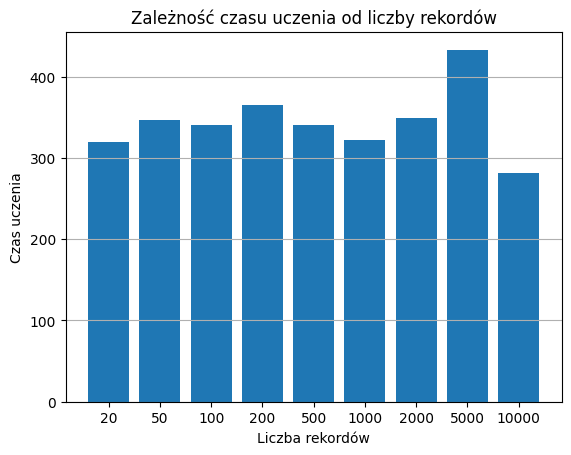

In [ ]:
x = range(len(quantities))

plt.figure()
plt.bar(x, results)
plt.xticks(x, quantities)
plt.xlabel("Liczba rekordów")
plt.ylabel("Czas uczenia")
plt.title("Zależność czasu uczenia od liczby rekordów")
plt.grid(axis="y")
plt.show()

Jak widać, nie ma większej różnicy - niezależnie od rozmiaru okna, model uczy się tak samo szybko. Zatem takie podejście powinno zostać zakończone powodzeniem.

## PREDYKCJA CZASU PRZEJAZDU

W analogiczny sposób będzie przebiegał trening modelu predykcji czasu przejazdu.

In [1]:
# "Checkpoint" nr 5
import polars as pl
import pandas as pd
import numpy as np
import lightgbm as lgb
import os
import pyarrow.parquet as pq
from pathlib import Path
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import math
import optuna
import pickle
from datetime import datetime
import matplotlib.pyplot as plt

c:\Users\przem\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def objective(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",

        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 31, 256),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 500),

        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": 1,

        "verbosity": -1,
        "seed": 42,
    }

    model = None

    for path in files:
        df = pl.read_parquet(path)

        X = df.drop(y_name).to_numpy()
        y = df[y_name].to_numpy()

        data = lgb.Dataset(X, label=y)

        model = lgb.train(
            params,
            data,
            num_boost_round=50,
            init_model=model
        )

    df_val = pl.read_parquet(test_file)

    X_val = df_val.drop(y_name).to_numpy()
    y_val = df_val[y_name].to_numpy()

    preds = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, preds)

    return rmse

In [8]:
def test_model(model, path, y_name):
    df_test = pl.read_parquet(path)
    X_test = df_test.drop(y_name).to_numpy()
    y_test = df_test[y_name].to_numpy()

    y_pred = model.predict(X_test)

    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(y_test.mean(), y_pred.mean())
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE:  {mae:.2f}")
    print(f"R2:   {r2:.3f}")

    mask = y_test > 0
    mape = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100
    print(f"MAPE: {mape:.2f}%")

    return rmse, mae, r2, mape

In [4]:
files = [f"processed/yellow_tripdata_20{f}-processed.parquet" for f in ["24-09", "24-10", "24-11", "24-12",
                                                                        "25-01", "25-02", "25-03", "25-04",
                                                                        "25-05", "25-06", "25-07", "25-08"]]
test_file = "processed/yellow_tripdata_2025-09-processed.parquet"
y_name = "trip_time"

In [5]:
study = optuna.create_study(direction="minimize")

[I 2026-01-25 22:37:32,916] A new study created in memory with name: no-name-cfa95a9c-94e8-41b1-8fea-525d2f0d4651


In [9]:
study.optimize(objective, n_trials=50)

[I 2026-01-25 23:00:33,339] Trial 1 finished with value: 1511.175019253275 and parameters: {'learning_rate': 0.02931014691625089, 'num_leaves': 178, 'min_data_in_leaf': 497, 'feature_fraction': 0.8636927454520651, 'bagging_fraction': 0.7221468483979935}. Best is trial 1 with value: 1511.175019253275.
[I 2026-01-25 23:11:47,189] Trial 2 finished with value: 1504.210325655789 and parameters: {'learning_rate': 0.06502851808812647, 'num_leaves': 195, 'min_data_in_leaf': 153, 'feature_fraction': 0.7549648446697039, 'bagging_fraction': 0.9488701848215473}. Best is trial 2 with value: 1504.210325655789.
[I 2026-01-25 23:23:52,723] Trial 3 finished with value: 1511.8725322817847 and parameters: {'learning_rate': 0.022221853226516777, 'num_leaves': 189, 'min_data_in_leaf': 354, 'feature_fraction': 0.6669921760898895, 'bagging_fraction': 0.6893677373856969}. Best is trial 2 with value: 1504.210325655789.
[I 2026-01-25 23:33:04,782] Trial 4 finished with value: 1513.476374241705 and parameters: {

In [10]:
print("Najlepszy wynik RMSE:", study.best_value)
print("Najlepsze parametry:")
print(study.best_params)

Najlepszy wynik RMSE: 1503.3293555946075
Najlepsze parametry:
{'learning_rate': 0.07771188842386337, 'num_leaves': 183, 'min_data_in_leaf': 116, 'feature_fraction': 0.9429579731830748, 'bagging_fraction': 0.8958277768976206}


In [11]:
best_params = study.best_params

best_params.update({
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "seed": 42,
})

In [12]:
model = None

for path in files:
    df = pl.read_parquet(path)

    X = df.drop(y_name).to_numpy()
    y = df[y_name].to_numpy()

    data = lgb.Dataset(X, label=y)

    model = lgb.train(
        best_params,
        data,
        num_boost_round=50,
        init_model=model
    )

In [13]:
test_model(model, "processed/yellow_tripdata_2025-09-processed.parquet", y_name)

1113.8633356196697 1094.0206374041697
RMSE: 1504.45
MAE:  188.03
R2:   0.240
MAPE: 45.65%


(1504.454734715497,
 188.0309101836892,
 0.23986010491377896,
 np.float64(45.65226923119483))

In [14]:
model.save_model("lgb_trip_time.txt")

## ZONE'Y

Na potrzeby aplikacji, istotne jest mapowanie ID miejsc na ich nazwy. Taksówki żółte - zgodnie z zasadami (źródło: Wikipedia) - mogą odbierać pasażerów z dowolnego miejsca w NYC, zatem _obowiązuje_ je cały zbiór.

In [1]:
# "Checkpoint" nr 6
import polars as pl
import pandas as pd
import numpy as np
import lightgbm as lgb
import os
import pyarrow.parquet as pq
from pathlib import Path
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import math
import optuna
import pickle
from datetime import datetime
import matplotlib.pyplot as plt

c:\Users\przem\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# app/backend/app/zones.py

def get_zones():
    path:str = "data/taxi_zone_lookup.csv"
    data = pd.read_csv(path)
    data = data.drop(columns=["Borough", "service_zone"])
    data_dict = data.to_dict()

    l1 = list(data_dict["LocationID"].values())
    l2 = list(data_dict["Zone"].values())

    result = {}

    for i in range(len(l1)):
        k = l1[i]
        v = l2[i]
        result[k] = v

    return result

if __name__ == '__main__':
    display(get_zones())


{1: 'Newark Airport',
 2: 'Jamaica Bay',
 3: 'Allerton/Pelham Gardens',
 4: 'Alphabet City',
 5: 'Arden Heights',
 6: 'Arrochar/Fort Wadsworth',
 7: 'Astoria',
 8: 'Astoria Park',
 9: 'Auburndale',
 10: 'Baisley Park',
 11: 'Bath Beach',
 12: 'Battery Park',
 13: 'Battery Park City',
 14: 'Bay Ridge',
 15: 'Bay Terrace/Fort Totten',
 16: 'Bayside',
 17: 'Bedford',
 18: 'Bedford Park',
 19: 'Bellerose',
 20: 'Belmont',
 21: 'Bensonhurst East',
 22: 'Bensonhurst West',
 23: 'Bloomfield/Emerson Hill',
 24: 'Bloomingdale',
 25: 'Boerum Hill',
 26: 'Borough Park',
 27: 'Breezy Point/Fort Tilden/Riis Beach',
 28: 'Briarwood/Jamaica Hills',
 29: 'Brighton Beach',
 30: 'Broad Channel',
 31: 'Bronx Park',
 32: 'Bronxdale',
 33: 'Brooklyn Heights',
 34: 'Brooklyn Navy Yard',
 35: 'Brownsville',
 36: 'Bushwick North',
 37: 'Bushwick South',
 38: 'Cambria Heights',
 39: 'Canarsie',
 40: 'Carroll Gardens',
 41: 'Central Harlem',
 42: 'Central Harlem North',
 43: 'Central Park',
 44: 'Charleston/Tot

Należy liczyć jeszcze odległość między strefami:

In [ ]:
import geopandas as gpd
from haversine import haversine, Unit

zones = gpd.read_file("contents/taxi_zones.shp")
zones_m = zones.to_crs(epsg=3857)

zones_m["centroid"] = zones_m.geometry.centroid.to_crs(epsg=4326)
zones_m = zones_m.set_geometry("centroid").to_crs(epsg=4326)

zones_m["lat"] = zones_m.centroid.y
zones_m["lon"] = zones_m.centroid.x

coords = {
    int(row["LocationID"]): (row["lat"], row["lon"])
    for _, row in zones_m.iterrows()
}

def calculate_trip_distance(from_id, to_id):
    return haversine(
        coords[int(from_id)],
        coords[int(to_id)],
        unit=Unit.MILES
    )

I z części teoretyczno-pogadankowej to tyle. Uprzątnięty kod znajdzie się w ostatecznym raportcie.